In [581]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import dill

import csv

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

# Загружаю целевую переменную, паралельно в потоке устанавливая тип данных "int8" для всех данных, кроме колонки "id".

In [2]:
credit_target =  pd.concat(
                     [pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\train_target.csv', usecols=['id']),
                      pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\train_target.csv').drop(columns='id').astype('int8')],
                          axis=1)
credit_target.tail()

,id,flag
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0
2999999,2999999,0


# Циклом загружаю и соединяю все таблицы для работы из файлов Parquet, паралельно в потоке устанавливая тип данных "int8" для всех данных, кроме колонки "id".

In [3]:
credit = pd.DataFrame()
for i in range(12):
  credit = pd.concat(
                     [credit,
                      pd.concat(
                                [pd.read_parquet(fr'C:\Users\VaL\PycharmProjects\Credit\train_data\train_data_{i}.pq', columns=['id']),
                                 pd.read_parquet(fr'C:\Users\VaL\PycharmProjects\Credit\train_data\train_data_{i}.pq').drop(columns='id').astype('int8')],
                          axis=1)]
                     )

In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26162717 entries, 0 to 2450629
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19  is_z

In [5]:
credit.id.nunique()

3000000

# Написал функции, чтобы полностью выводить колонки, где есть пропущенные значения и бесконечность

In [6]:
def emptyval(dframe):
    arr = []
    for col, n in zip(dframe, range(len(dframe))):
        temp = dframe.isnull()[col].sum()
        if temp != 0:
            print(f'{n}: {temp} {col}')
    print('Done')

In [7]:
def infval(dframe):
    arr = []
    for col, n in zip(dframe, range(len(dframe))):
        temp = dframe[col].isin([np.inf, -np.inf]).sum()
        if temp != 0:
            print(f'{n}: {temp} {col}')
    print('Done')

In [8]:
emptyval(credit)

Done


# Циклом вывожу уникальные значения по всем колонкам, чтобы найти то, что можно удалить

In [9]:
for col, n in zip(credit, range(len(credit.columns))):
    print(f'{n}: {col}: {credit[col].unique()}')

0: id: [      0       1       2 ... 2999997 2999998 2999999]
1: rn: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58]
2: pre_since_opened: [18  4  5  3  2  1  7  8 15 14 10 13 12  0  6  9 19 17 11 16]
3: pre_since_confirmed: [ 9  1 12  0  7  3  4 14  6  8  5 16  2 10 17 11 13 15]
4: pre_pterm: [ 2 14  4  9 15 11  1 12 13  7  8  0 16 17 10  6  3  5]
5: pre_fterm: [ 3 14  8 12  2 13 10 15  6  0 11  9  1 16  7  5  4]
6: pre_till_pclose: [16 12  1 11 14  8  9 13  6 15  7  3  2  5  4 10  0]
7: pre_till_fclose: [10 12 11  7 14  8  1 13  5  3 15  2  6  9  0  4]
8: pre_loans_credit_limit: [11  0 12 10  4 15  2 16  1  6  3 14 19 13 18  5 17  8  7  9]
9: pre_loans_next_pay_summ: [3 0 2 5 4 1 6]
10: pre_loans_outstanding: [3 5 1 2 4]
11: pre_loans_total_overdue: [0 1]
12: pre_loans_max_overdue_sum: [2 1 3 0]
13: pre_loans_credit_cost_rate: [11  8  4  3 13  0  7  5  9  1 

# Группирую таблицу по идентификатору и суммирую все остальные значения

### Функция для вывода бинарных колонок

In [240]:
def binarycols(dframe):
    cols = []
    for col, n in zip(dframe, range(len(dframe.columns))):
          if dframe[col].unique().sum() == 1:
                cols.append(col)
    return cols

In [242]:
cols = binarycols(credit)
cols

['pre_loans_total_overdue',
 'is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans3060',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_over2limit',
 'is_zero_maxover2limit',
 'pclose_flag',
 'fclose_flag']

In [149]:
credit1 = credit.drop(columns=cols, axis=1)
cols.append('id')
credit2 = credit[cols]

In [169]:
dfa = credit1.groupby(['id'], as_index=False).sum().add_prefix('NEW_').reset_index(drop=True)
dfb = credit2.groupby(['id'], as_index=False).max().add_prefix('NEW_').reset_index(drop=True)

In [243]:
binarycols(dfb)

['NEW_pre_loans_total_overdue',
 'NEW_is_zero_loans5',
 'NEW_is_zero_loans530',
 'NEW_is_zero_loans3060',
 'NEW_is_zero_loans6090',
 'NEW_is_zero_loans90',
 'NEW_is_zero_util',
 'NEW_is_zero_over2limit',
 'NEW_is_zero_maxover2limit',
 'NEW_pclose_flag',
 'NEW_fclose_flag']

In [182]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 50 columns):
 #   Column                             Dtype
---  ------                             -----
 0   NEW_id                             int64
 1   NEW_rn                             int64
 2   NEW_pre_since_opened               int64
 3   NEW_pre_since_confirmed            int64
 4   NEW_pre_pterm                      int64
 5   NEW_pre_fterm                      int64
 6   NEW_pre_till_pclose                int64
 7   NEW_pre_till_fclose                int64
 8   NEW_pre_loans_credit_limit         int64
 9   NEW_pre_loans_next_pay_summ        int64
 10  NEW_pre_loans_outstanding          int64
 11  NEW_pre_loans_max_overdue_sum      int64
 12  NEW_pre_loans_credit_cost_rate     int64
 13  NEW_pre_loans5                     int64
 14  NEW_pre_loans530                   int64
 15  NEW_pre_loans3060                  int64
 16  NEW_pre_loans6090                  int64
 17  NEW_pre_

In [183]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 12 columns):
 #   Column                       Dtype
---  ------                       -----
 0   NEW_id                       int64
 1   NEW_pre_loans_total_overdue  int8 
 2   NEW_is_zero_loans5           int8 
 3   NEW_is_zero_loans530         int8 
 4   NEW_is_zero_loans3060        int8 
 5   NEW_is_zero_loans6090        int8 
 6   NEW_is_zero_loans90          int8 
 7   NEW_is_zero_util             int8 
 8   NEW_is_zero_over2limit       int8 
 9   NEW_is_zero_maxover2limit    int8 
 10  NEW_pclose_flag              int8 
 11  NEW_fclose_flag              int8 
dtypes: int64(1), int8(11)
memory usage: 54.4 MB


# Устанавливаю тип данных "int16" для всех данных, кроме колонки "id", так как "int8" тут будет недостаточно.

In [184]:
dfc = dfa.drop(columns='NEW_id').astype('int16')
dfc['NEW_id'] = dfa.NEW_id
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 50 columns):
 #   Column                             Dtype
---  ------                             -----
 0   NEW_rn                             int16
 1   NEW_pre_since_opened               int16
 2   NEW_pre_since_confirmed            int16
 3   NEW_pre_pterm                      int16
 4   NEW_pre_fterm                      int16
 5   NEW_pre_till_pclose                int16
 6   NEW_pre_till_fclose                int16
 7   NEW_pre_loans_credit_limit         int16
 8   NEW_pre_loans_next_pay_summ        int16
 9   NEW_pre_loans_outstanding          int16
 10  NEW_pre_loans_max_overdue_sum      int16
 11  NEW_pre_loans_credit_cost_rate     int16
 12  NEW_pre_loans5                     int16
 13  NEW_pre_loans530                   int16
 14  NEW_pre_loans3060                  int16
 15  NEW_pre_loans6090                  int16
 16  NEW_pre_loans90                    int16
 17  NEW_pre_

In [188]:
df1 = dfc.merge(dfb, on='NEW_id', how='inner')

In [189]:
df1.tail()

,NEW_rn,NEW_pre_since_opened,NEW_pre_since_confirmed,NEW_pre_pterm,NEW_pre_fterm,NEW_pre_till_pclose,NEW_pre_till_fclose,NEW_pre_loans_credit_limit,NEW_pre_loans_next_pay_summ,NEW_pre_loans_outstanding,...,NEW_is_zero_loans5,NEW_is_zero_loans530,NEW_is_zero_loans3060,NEW_is_zero_loans6090,NEW_is_zero_loans90,NEW_is_zero_util,NEW_is_zero_over2limit,NEW_is_zero_maxover2limit,NEW_pclose_flag,NEW_fclose_flag
2999995,66,97,101,98,98,97,97,81,25,35,...,1,1,1,1,1,1,1,1,1,1
2999996,91,104,148,117,110,82,89,151,25,40,...,1,1,1,1,1,1,1,1,1,1
2999997,55,81,78,85,78,82,91,70,24,32,...,1,1,1,1,1,1,1,1,1,1
2999998,15,58,46,39,47,30,39,57,13,18,...,1,1,1,1,1,1,1,1,1,1
2999999,78,77,110,92,114,99,105,122,35,33,...,1,1,1,1,1,1,1,1,1,1


In [190]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 61 columns):
 #   Column                             Dtype
---  ------                             -----
 0   NEW_rn                             int16
 1   NEW_pre_since_opened               int16
 2   NEW_pre_since_confirmed            int16
 3   NEW_pre_pterm                      int16
 4   NEW_pre_fterm                      int16
 5   NEW_pre_till_pclose                int16
 6   NEW_pre_till_fclose                int16
 7   NEW_pre_loans_credit_limit         int16
 8   NEW_pre_loans_next_pay_summ        int16
 9   NEW_pre_loans_outstanding          int16
 10  NEW_pre_loans_max_overdue_sum      int16
 11  NEW_pre_loans_credit_cost_rate     int16
 12  NEW_pre_loans5                     int16
 13  NEW_pre_loans530                   int16
 14  NEW_pre_loans3060                  int16
 15  NEW_pre_loans6090                  int16
 16  NEW_pre_loans90                    int16
 17  NEW_pre_

# Создаю новые переменные в основном через отношения одних значений к другим, находя долю.
Например, 'pterm/fterm' - отношение планового количесвта дней с даты сбора данных до даты закртытия кредита к фактическому

In [191]:
for col, n in zip(df1, range(len(df1.columns))):
    print(f'{n}: {col}: {df1[col].unique()}')

0: NEW_rn: [  55  105    6  120    1   10  171    3  210   21   78   15   45  136
   66  190   28  153   91  231   36  595  465  351  325  435  276  300
  253  378  561  496  406  528  703  946  741  630  666  861 1326  780
  990 1081  820  903 1275 1035 1225 1128 1485 1540 1176 1711]
1: NEW_pre_since_opened: [ 81 160  25 105  12  35 166  14  33   6 156  52 149  30  16  94  24  15
   7 138 127  99  51  37 176  88 171  32  40 119  62 174  63  56 112  18
  42 129  21  89  47 120 100 134  96  67  75  46  39  86 214  22  31   9
  91  57  48  66 374  82  44 266  28   0  49   5  10  36  97  38 128  61
  73 227  11  71 151 101 246 181  77 131  59  26   4  69  19  79  45 165
 140 196 121  72 103 148 141  74  76  41 104  68  58 113 152 126   1 154
  54 123 173  27  55 322 191  13  29 108  98  34  85 159 110  43 135 194
 145 167 155  20 116 146 201  50   2 130 195  70   8  93 118 180 272  60
  23 175 150 179 107 115 125 122  90  17 263 132  64 133 178 199 144 211
  84 109  87  95  53  92 189 106

10: NEW_pre_loans_max_overdue_sum: [ 20  27   5  30   2  36   4   6  40  11  25  12  10  17   8  33  22  34
  15  21  32  13  26  24  18   9  42  19  16  68  63   3  14   7  52  29
  23  51  28  31  38  59  39  35  46  49  48  44  45  37  41  43  58  65
   1  61  50  57  47  53  55  56  62  64  78  54  86  60  75  66  70  88
  72  67  74  73  71  69  83  95  92  76  77  82  79  87  80  81  84  85
 100  90  91  93  97  89   0 106 108  94 116]
11: NEW_pre_loans_credit_cost_rate: [ 80  52  12  67   0  24  72   4   8  95  40  69  19  34  33  15  17   2
  78   3  23  16  79  21  27  35  44  22 138   7  47  11  28  97  31  65
  56  49  50  45  38  26  96  14  25  39  13 183  37  53 125   5   9  20
  42  30  90 114   1  75  18 117  54  51  36  46  10  82  62  32 126  58
  57  83  74   6 135  64  70  84  55  41  89  29  81 121  98 124  66  59
  61  43  76  93  68  85 111 116 104 120  73  88  63 173  94  48 108  91
  60 110  99 145 132 100 106 119  77  71 115  92 102 105  87 169 134 103
 164 14

21: NEW_enc_paym_1: [  0  11   3   2   4   6   1  18   7   8  15   9   5  22  10  20  12  27
  33  21  16  14  48  58  17  30  19  44  67  37  38  13  69  24  31  51
  45  28  36  23  43  46  42  35  55  53  25  87  49  26  61  60  34  41
  40  29  39  78  72  50  57  54  32  62  79  47  66  59  64  56  70  63
  75  52  88  68  71  65  85  82  96  73  89  74  81  76 100 105  84  92
  77  91  86  80  99 102  93  90  94 117 111  97 101  83 108 103]
22: NEW_enc_paym_2: [  6  10   3   0   1  18   7   4   9   2  16   8  14  12   5  39  27  11
  15  36  13  30  21  23  22  24  63  78  44  45  69  50  40  71  19  52
  57  17  34  43  42  31  25  58  49  33  54  47  48  51  96  55  37  84
  41  29  66  20  35  28  53 102  26  38  87  32  46  68  60  56  72  82
  59  73  70  90  64  74  79  61  75  81  76  67  65  62 101  93  99  91
  86 114  77 123 109 105  88  94 110 108  85  83  80  92  89  97 100 111
 117 103 106 112  95 119 115 104 118  98]
23: NEW_enc_paym_3: [  6   9   3   1   2  18   0 

36: NEW_enc_paym_16: [ 21  30   8  24   3   9  33   6   0  45  16  12   4  27  39  43  15  42
  25  38  18  19   7  82  73  10  37  51  63  23  57  26  13  58  36  66
  35  48  60  14  11  22  61  46  62  20  29  54  31  41  17  87  96  34
   1   5  76  32  68  72  70  55  28   2  75  52  81  78  64  40  53  67
  47  56  77  49  84  71  69 101 129 103  59  44  90  50 120  99  86  79
  74  65  80  94  93  92  83  85 105  91  89  88  97 117 147 102 123 108
 114  98  95 126 104 112 111 106 100 107 118 121 109 144 132 115 131 122
 113 110 135 127 119 153 116 133 162]
37: NEW_enc_paym_17: [ 21  30   7  24   3   9  34   6   0  48  15  12  27  39  42  33  16  25
  37  18  19  20  13  10  88  75  31  40  51  28  63  57  58  36  46  45
  66   4  17  60  38  22   8  23  54  11  41  32  87  96   1  43  68   5
  72  69  14  50   2  52  29  83  55  78  64  79  73  26  76  35  49  67
  65  70  47  62  81  84 100  61 129 102  53  44  56  98  90  59 120  99
  71  82  93  85  86  74 105  91  89  80  97

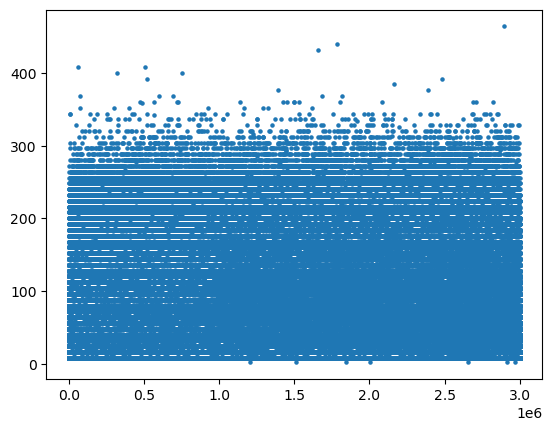

In [196]:
plt.scatter(df1.index, df1.NEW_pre_loans90, s=5)
plt.show()

In [846]:
def newfeatures(dframe):
    dframe2 = dframe.copy()
    
    dframe2['binary_fact_close'] = dframe2.apply(lambda x: 1 if x['NEW_pre_fterm'] <= x['NEW_pre_pterm'] else 0, axis=1).astype('int8')
    
    s5 = dframe2.NEW_pre_loans5.median()
    s530 = dframe2.NEW_pre_loans530.median()
    s3060 = dframe2.NEW_pre_loans3060.median()
    s6090 = dframe2.NEW_pre_loans6090.median()
    s90 = dframe2.NEW_pre_loans90.median()
    
    dframe2['binary_loans5'] = dframe2.apply(lambda x: 1 if x['NEW_pre_loans5'] <= s5 else 0, axis=1).astype('int8')
    dframe2['binary_loans530'] = dframe2.apply(lambda x: 1 if x['NEW_pre_loans530'] <= s530 else 0, axis=1).astype('int8')
    dframe2['binary_loans3060'] = dframe2.apply(lambda x: 1 if x['NEW_pre_loans3060'] <= s3060 else 0, axis=1).astype('int8')
    dframe2['binary_loans6090'] = dframe2.apply(lambda x: 1 if x['NEW_pre_loans6090'] <= s6090 else 0, axis=1).astype('int8')
    dframe2['binary_loans90'] = dframe2.apply(lambda x: 1 if x['NEW_pre_loans90'] <= s90 else 0, axis=1).astype('int8')

    dframe2['pterm/fterm'] = (dframe2.NEW_pre_pterm / dframe2.NEW_pre_fterm).astype('float16')
    dframe2['pclose/fclose'] = (dframe2.NEW_pre_till_pclose / dframe2.NEW_pre_till_fclose).astype('float16')
    dframe2['loans_next_pay_summ/loans_outstanding'] = (dframe2.NEW_pre_loans_next_pay_summ / dframe2.NEW_pre_loans_outstanding).astype('float16')
    dframe2['loans5/zero_loans5'] = (dframe2.NEW_pre_loans5 / dframe2.NEW_is_zero_loans5).astype('float16')
    dframe2['loans530/zero_loans530'] = (dframe2.NEW_pre_loans530 / dframe2.NEW_is_zero_loans530).astype('float16')
    dframe2['loans3060/zero_loans3060'] = (dframe2.NEW_pre_loans3060 / dframe2.NEW_is_zero_loans3060).astype('float16')
    dframe2['loans6090/zero_loans6090'] = (dframe2.NEW_pre_loans6090 / dframe2.NEW_is_zero_loans6090).astype('float16')
    dframe2['loans90/zero_loans90'] = (dframe2.NEW_pre_loans90 / dframe2.NEW_is_zero_loans90).astype('float16')

    dframe2['enc_paym_sum'] = dframe2.NEW_enc_paym_0
    for i in range(1, 25):
        dframe2['enc_paym_sum'] = (dframe2['enc_paym_sum'] + dframe2[f'NEW_enc_paym_{i}']).astype('int16')
    return dframe2

In [847]:
df2 = newfeatures(df1)

In [848]:
df2.tail()

,NEW_rn,NEW_pre_since_opened,NEW_pre_since_confirmed,NEW_pre_pterm,NEW_pre_fterm,NEW_pre_till_pclose,NEW_pre_till_fclose,NEW_pre_loans_credit_limit,NEW_pre_loans_next_pay_summ,NEW_pre_loans_outstanding,...,binary_loans90,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
2999995,66,97,101,98,98,97,97,81,25,35,...,0,1.000000,1.000000,0.714355,66.0,170.0,55.0,44.0,88.0,359
2999996,91,104,148,117,110,82,89,151,25,40,...,0,1.063477,0.921387,0.625000,78.0,208.0,65.0,52.0,104.0,501
2999997,55,81,78,85,78,82,91,70,24,32,...,0,1.089844,0.900879,0.750000,60.0,160.0,50.0,40.0,80.0,404
2999998,15,58,46,39,47,30,39,57,13,18,...,1,0.829590,0.769043,0.722168,30.0,80.0,25.0,20.0,40.0,332
2999999,78,77,110,92,114,99,105,122,35,33,...,0,0.807129,0.942871,1.060547,72.0,192.0,60.0,48.0,96.0,415


In [849]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 76 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   NEW_rn                                 int16  
 1   NEW_pre_since_opened                   int16  
 2   NEW_pre_since_confirmed                int16  
 3   NEW_pre_pterm                          int16  
 4   NEW_pre_fterm                          int16  
 5   NEW_pre_till_pclose                    int16  
 6   NEW_pre_till_fclose                    int16  
 7   NEW_pre_loans_credit_limit             int16  
 8   NEW_pre_loans_next_pay_summ            int16  
 9   NEW_pre_loans_outstanding              int16  
 10  NEW_pre_loans_max_overdue_sum          int16  
 11  NEW_pre_loans_credit_cost_rate         int16  
 12  NEW_pre_loans5                         int16  
 13  NEW_pre_loans530                       int16  
 14  NEW_pre_loans3060                      int16  
 15

In [850]:
emptyval(df2)

67: 1 pterm/fterm
68: 83 pclose/fclose
70: 910 loans5/zero_loans5
71: 500 loans530/zero_loans530
Done


In [851]:
infval(df2)

67: 10964 pterm/fterm
68: 4919 pclose/fclose
70: 14680 loans5/zero_loans5
71: 45057 loans530/zero_loans530
72: 11463 loans3060/zero_loans3060
73: 7194 loans6090/zero_loans6090
74: 8456 loans90/zero_loans90
Done


# Заменяю пустые и бесконечные значения на 0.

In [852]:
df3 = df2.replace([np.inf, -np.inf, np.nan], 0)

In [253]:
emptyval(df3)

Done


In [254]:
infval(df3)

Done


In [853]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 76 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   NEW_rn                                 int16  
 1   NEW_pre_since_opened                   int16  
 2   NEW_pre_since_confirmed                int16  
 3   NEW_pre_pterm                          int16  
 4   NEW_pre_fterm                          int16  
 5   NEW_pre_till_pclose                    int16  
 6   NEW_pre_till_fclose                    int16  
 7   NEW_pre_loans_credit_limit             int16  
 8   NEW_pre_loans_next_pay_summ            int16  
 9   NEW_pre_loans_outstanding              int16  
 10  NEW_pre_loans_max_overdue_sum          int16  
 11  NEW_pre_loans_credit_cost_rate         int16  
 12  NEW_pre_loans5                         int16  
 13  NEW_pre_loans530                       int16  
 14  NEW_pre_loans3060                      int16  
 15

In [854]:
df3 = df3.rename(columns={'NEW_id': 'id'})

# Соединяю основную таблицу с целевой переменной по колонке "id".

In [855]:
df4 = credit_target.merge(df3, on='id', how='inner')

In [856]:
df4.tail()

,id,flag,NEW_rn,NEW_pre_since_opened,NEW_pre_since_confirmed,NEW_pre_pterm,NEW_pre_fterm,NEW_pre_till_pclose,NEW_pre_till_fclose,NEW_pre_loans_credit_limit,...,binary_loans90,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
2999995,2999995,0,66,97,101,98,98,97,97,81,...,0,1.000000,1.000000,0.714355,66.0,170.0,55.0,44.0,88.0,359
2999996,2999996,0,91,104,148,117,110,82,89,151,...,0,1.063477,0.921387,0.625000,78.0,208.0,65.0,52.0,104.0,501
2999997,2999997,0,55,81,78,85,78,82,91,70,...,0,1.089844,0.900879,0.750000,60.0,160.0,50.0,40.0,80.0,404
2999998,2999998,0,15,58,46,39,47,30,39,57,...,1,0.829590,0.769043,0.722168,30.0,80.0,25.0,20.0,40.0,332
2999999,2999999,0,78,77,110,92,114,99,105,122,...,0,0.807129,0.942871,1.060547,72.0,192.0,60.0,48.0,96.0,415


In [857]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 77 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   id                                     int64  
 1   flag                                   int8   
 2   NEW_rn                                 int16  
 3   NEW_pre_since_opened                   int16  
 4   NEW_pre_since_confirmed                int16  
 5   NEW_pre_pterm                          int16  
 6   NEW_pre_fterm                          int16  
 7   NEW_pre_till_pclose                    int16  
 8   NEW_pre_till_fclose                    int16  
 9   NEW_pre_loans_credit_limit             int16  
 10  NEW_pre_loans_next_pay_summ            int16  
 11  NEW_pre_loans_outstanding              int16  
 12  NEW_pre_loans_max_overdue_sum          int16  
 13  NEW_pre_loans_credit_cost_rate         int16  
 14  NEW_pre_loans5                         int16  
 15

# Строю графики распределений для определения выбросов и лишних значений

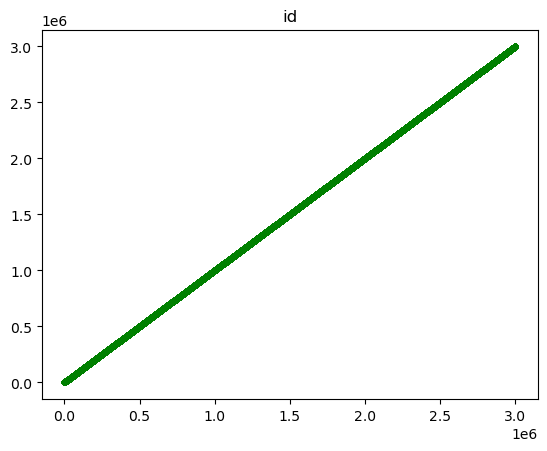

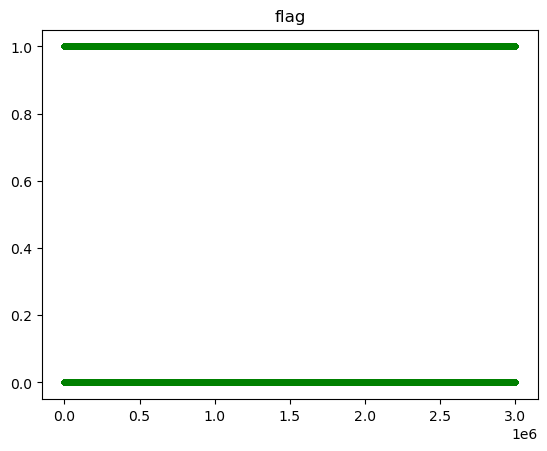

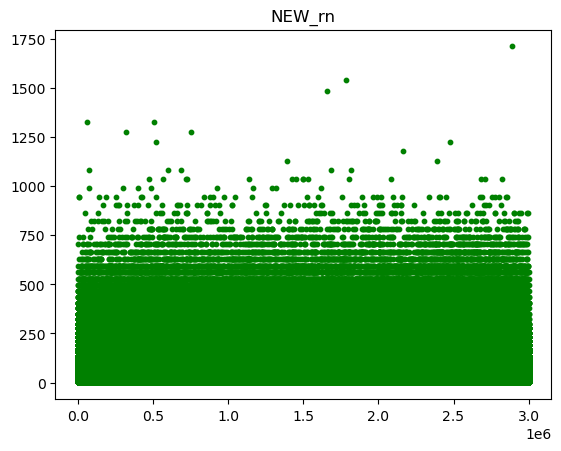

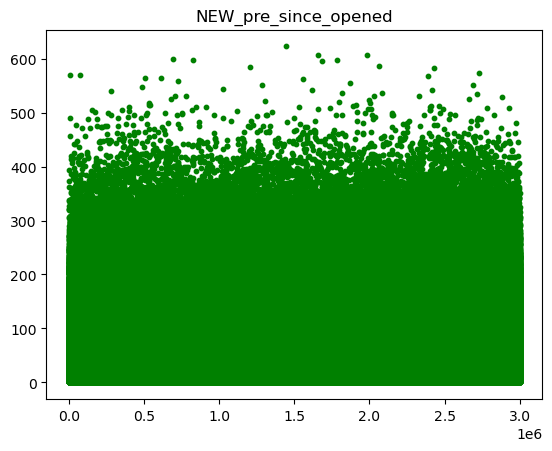

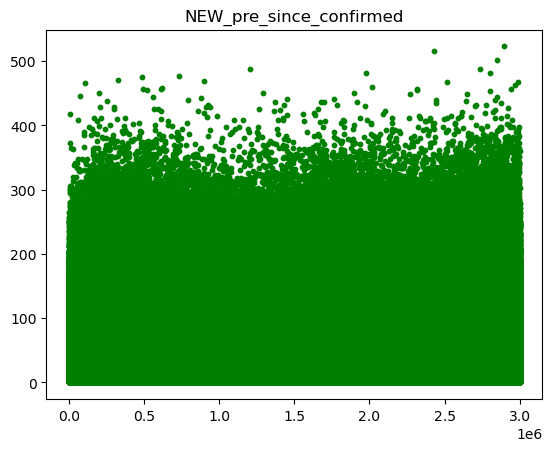

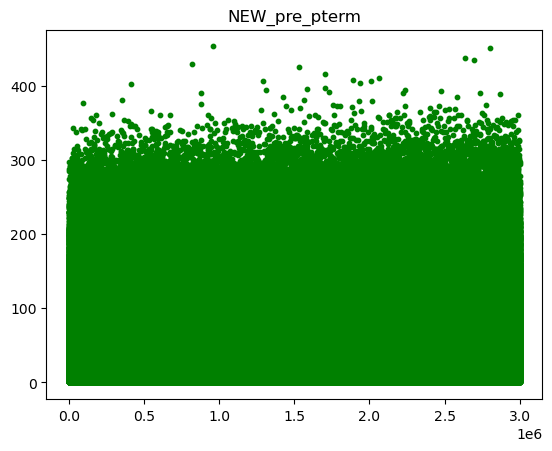

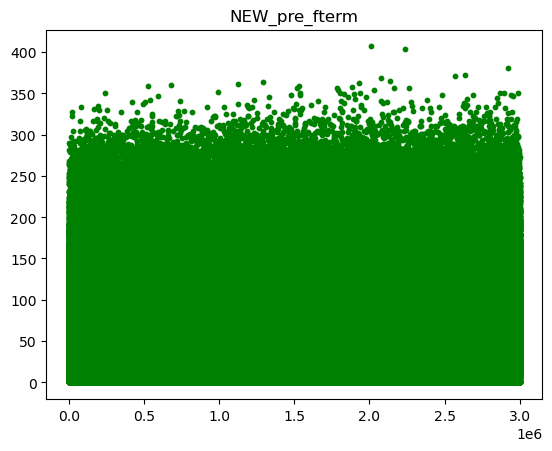

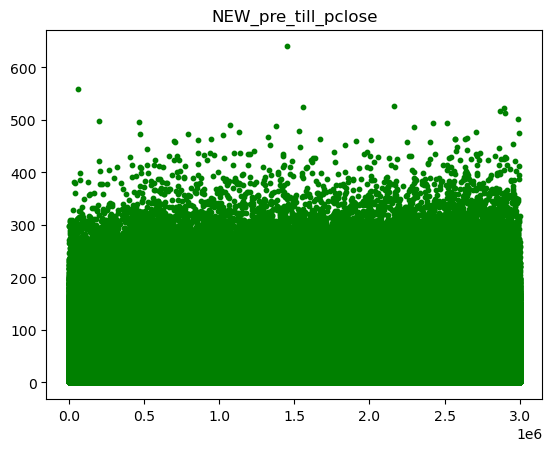

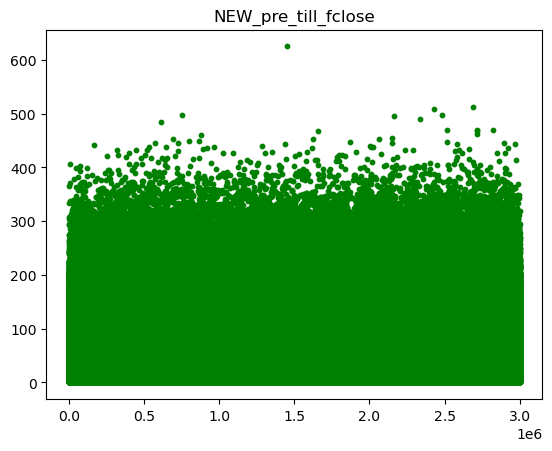

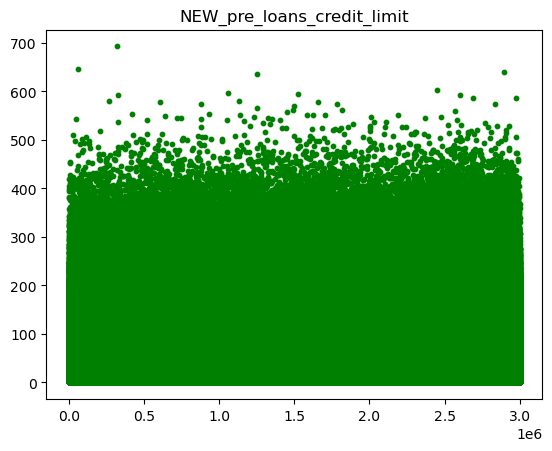

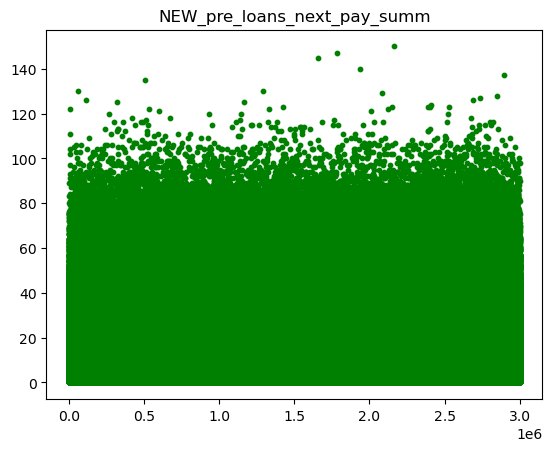

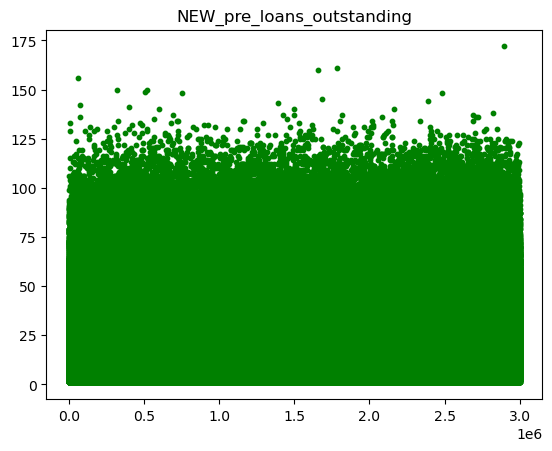

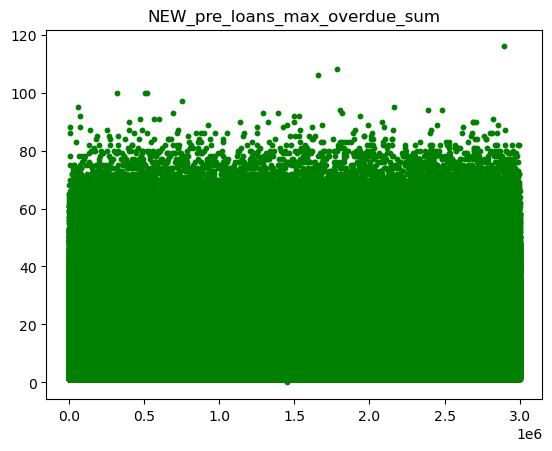

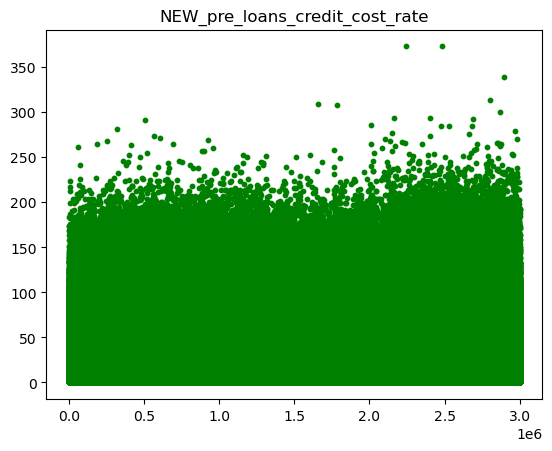

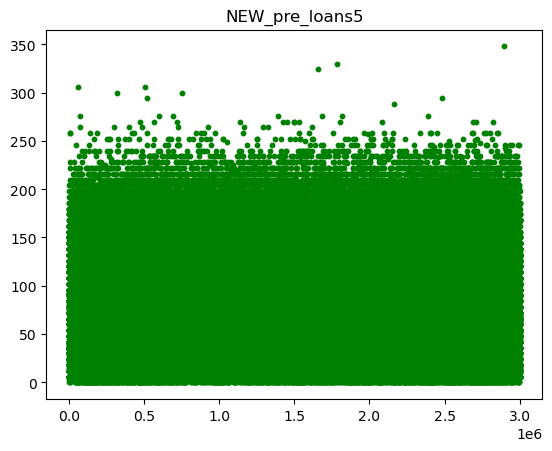

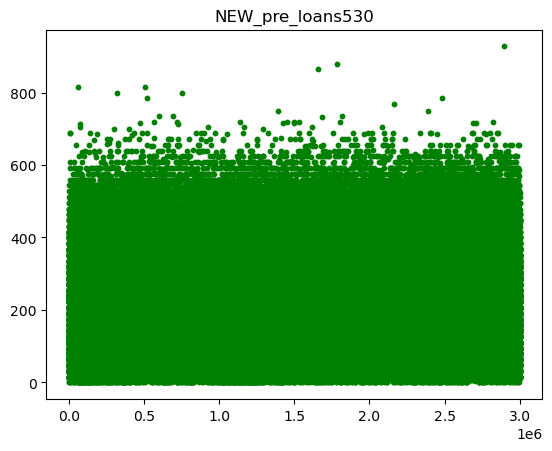

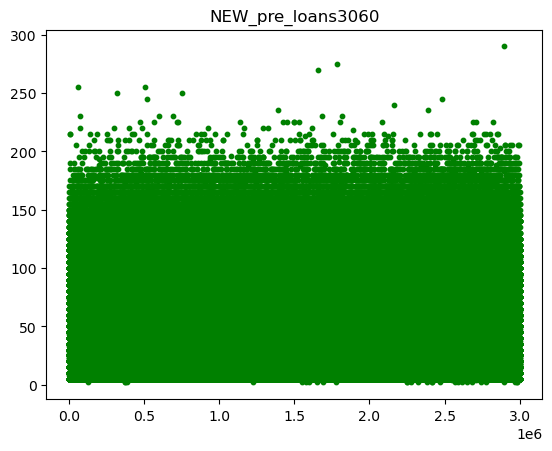

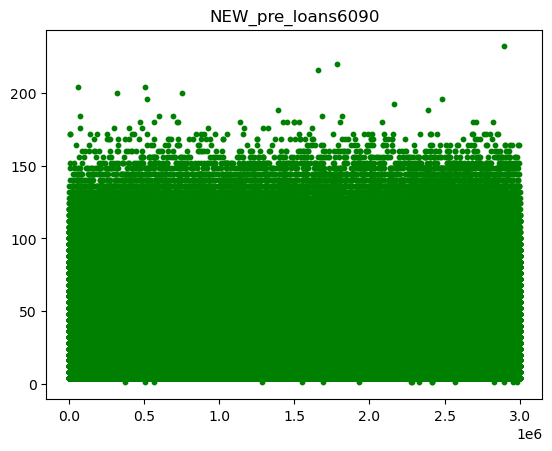

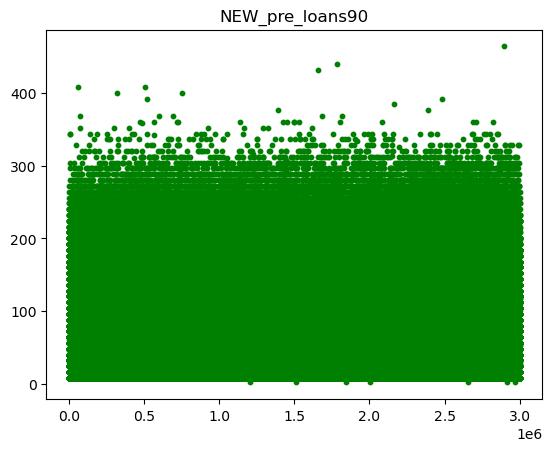

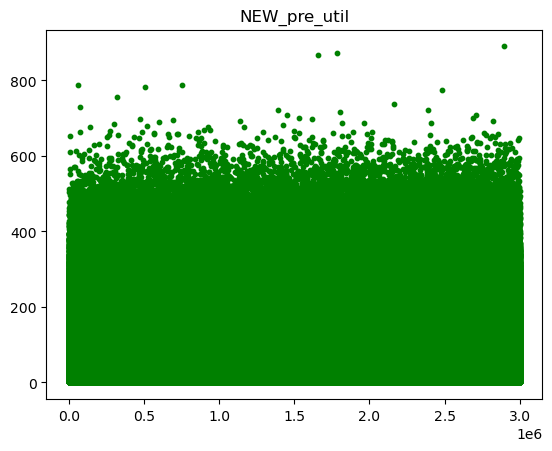

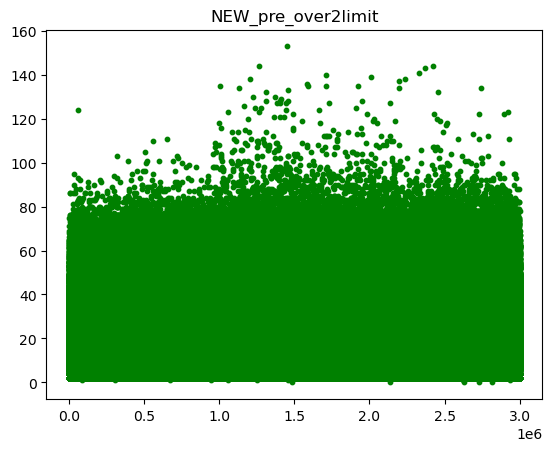

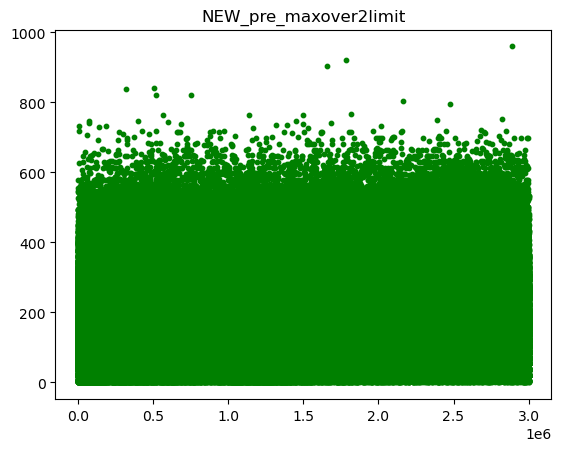

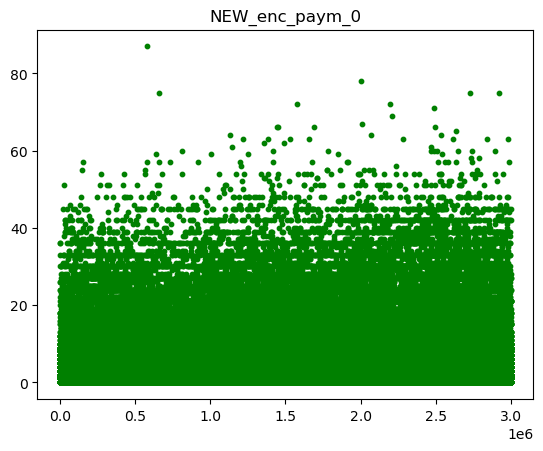

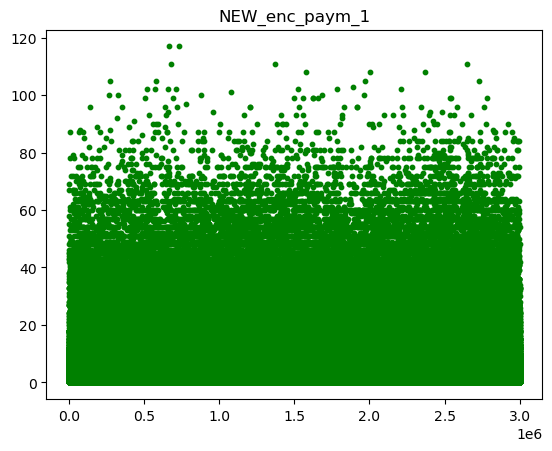

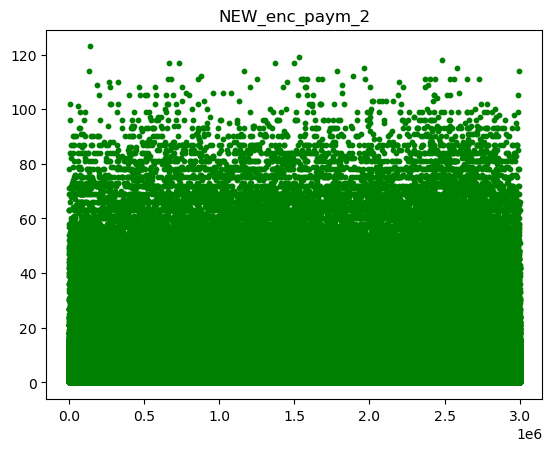

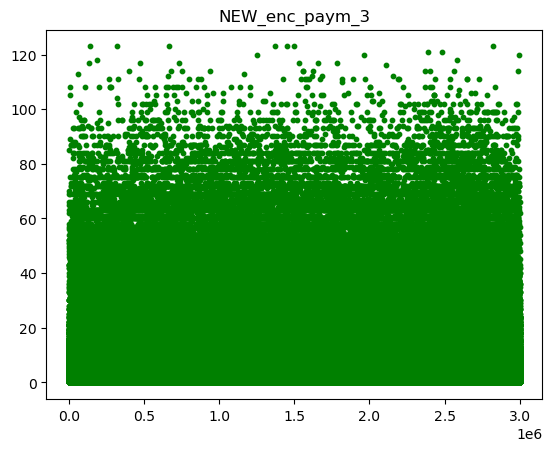

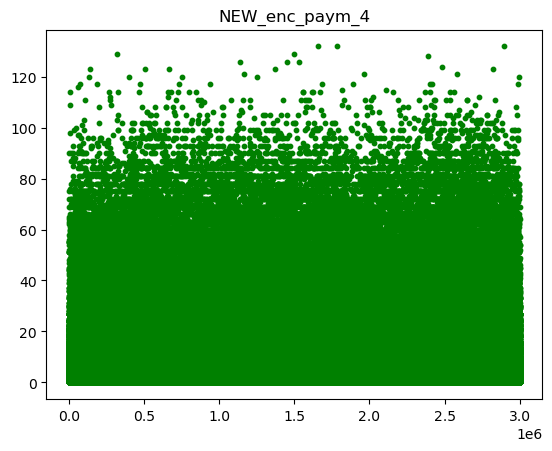

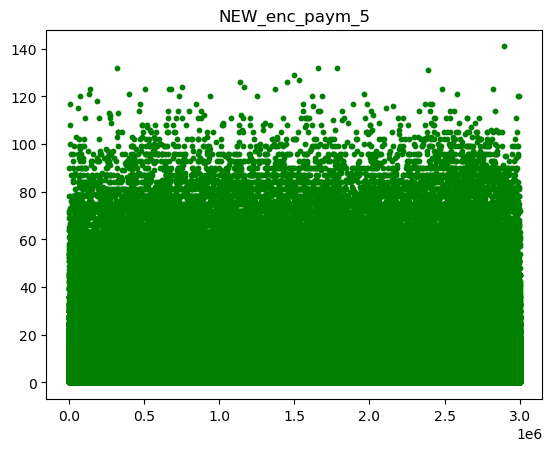

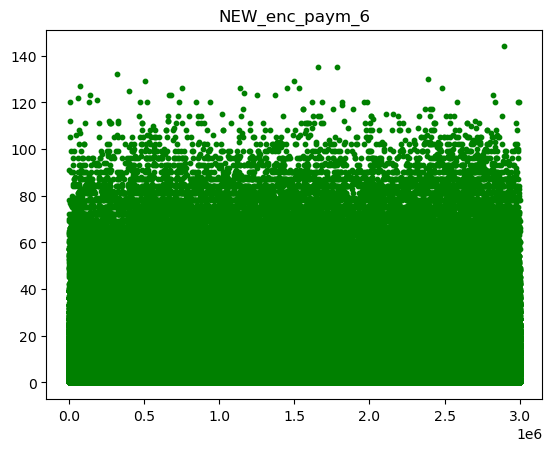

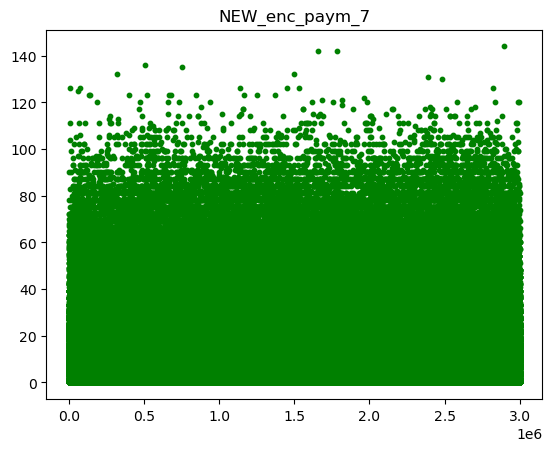

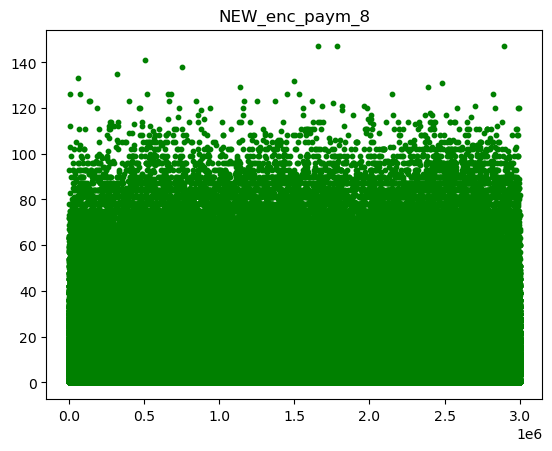

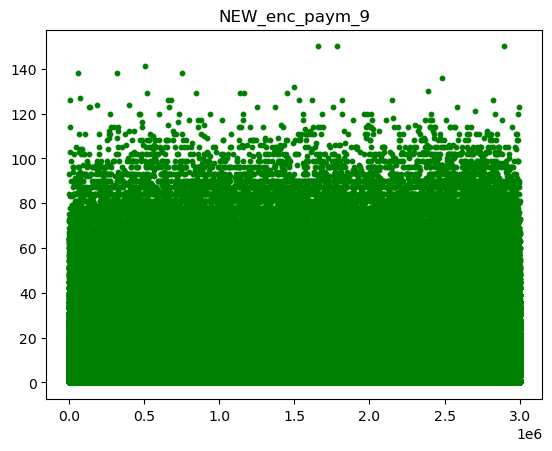

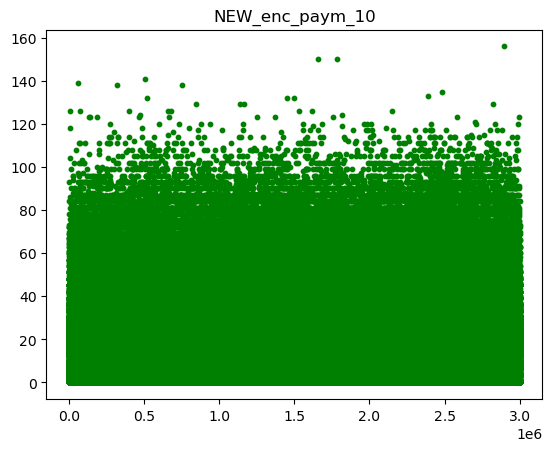

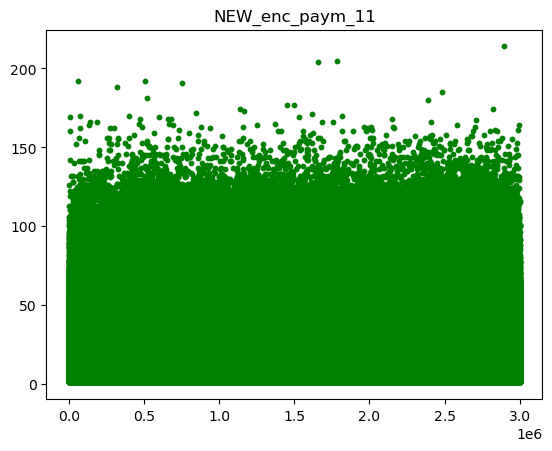

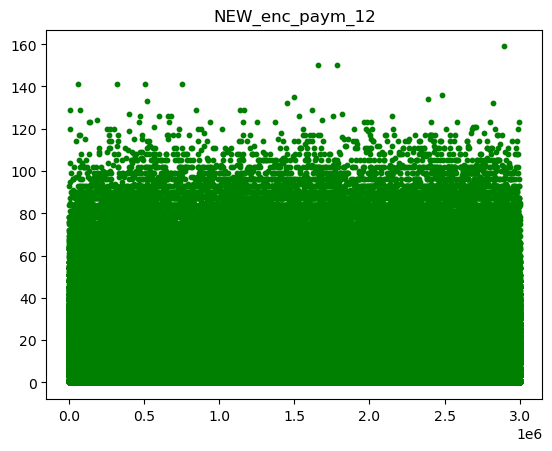

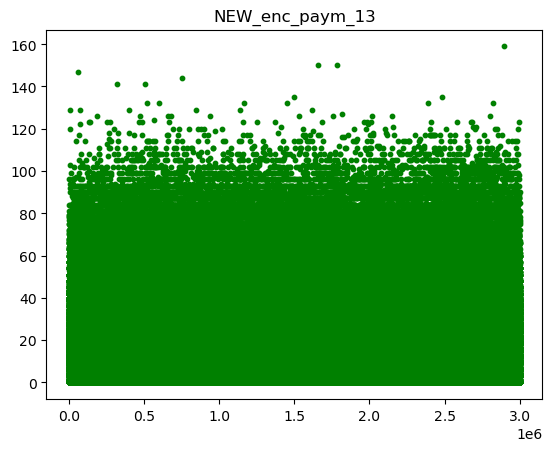

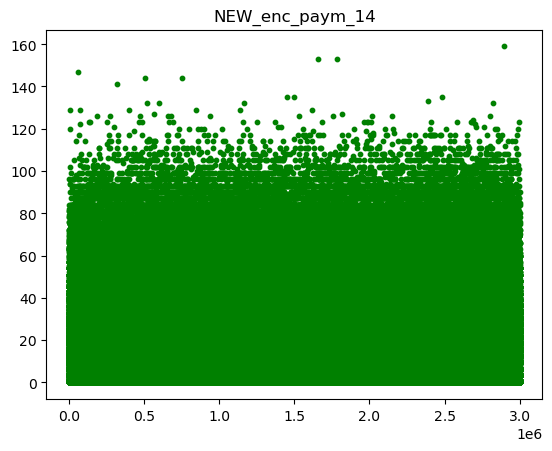

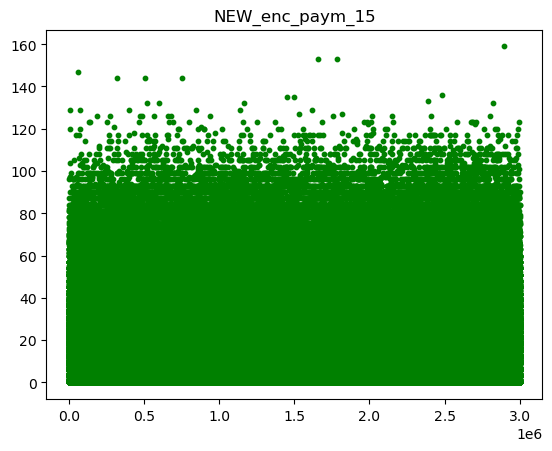

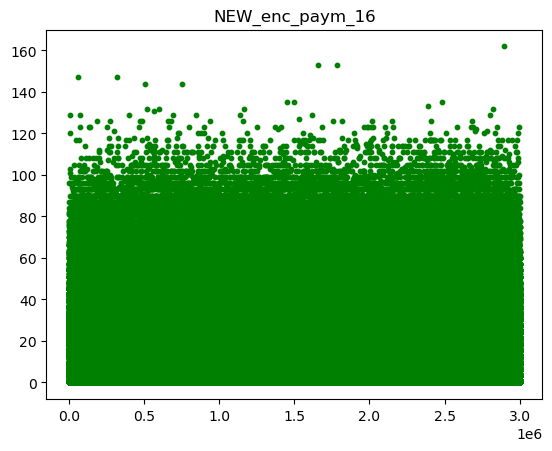

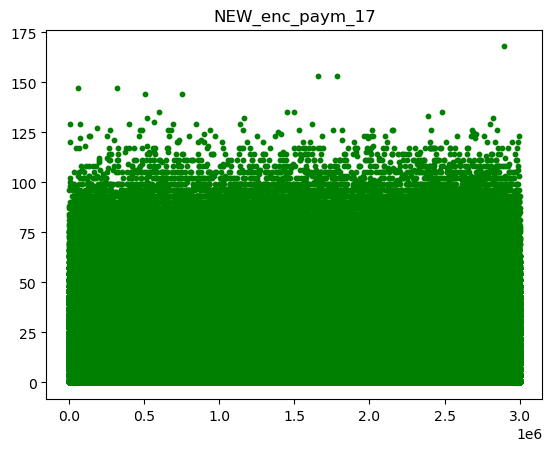

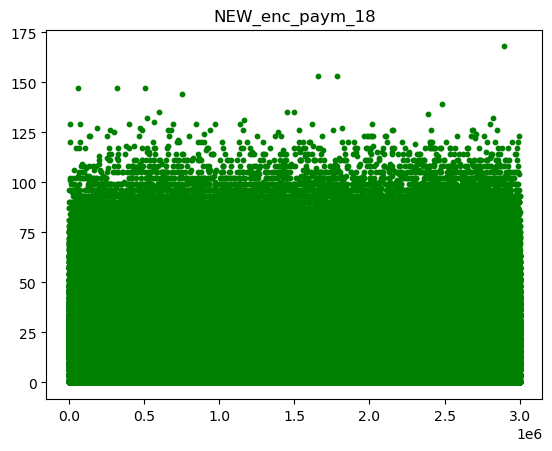

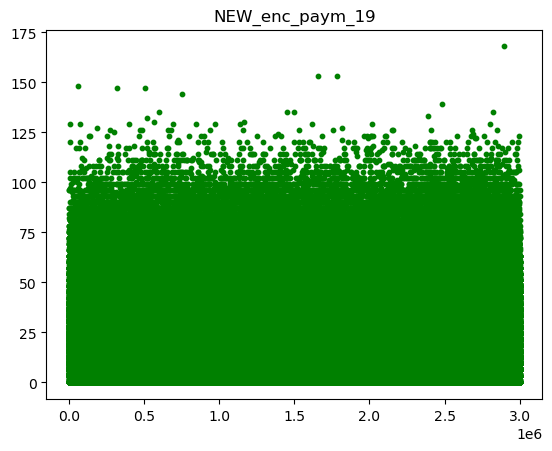

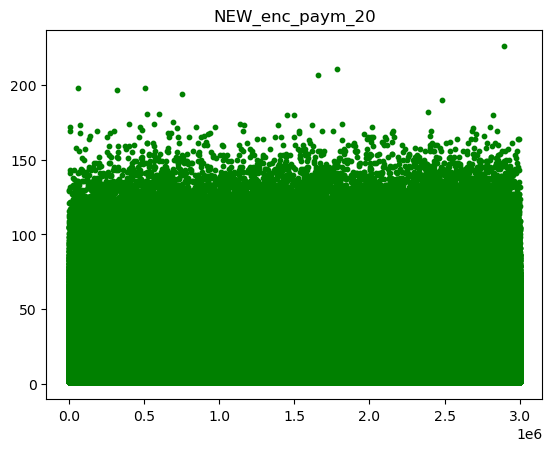

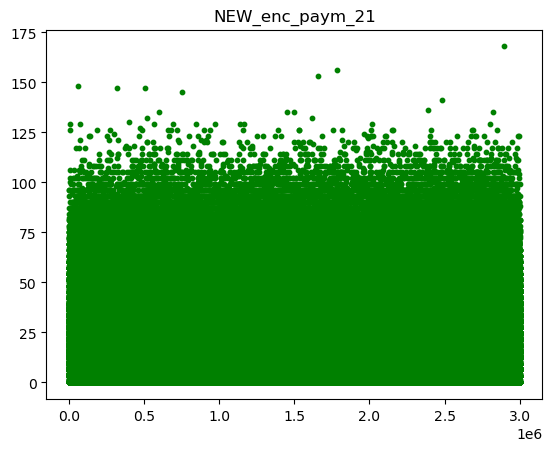

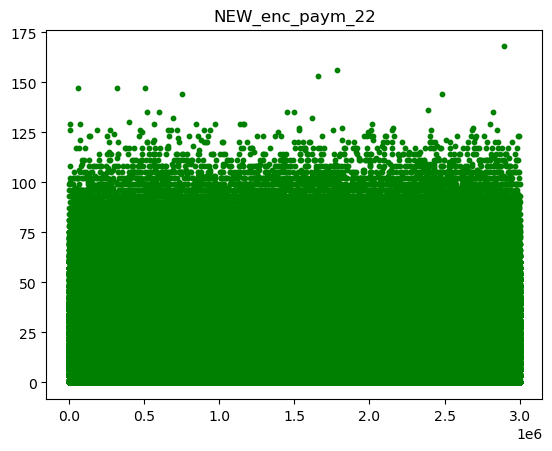

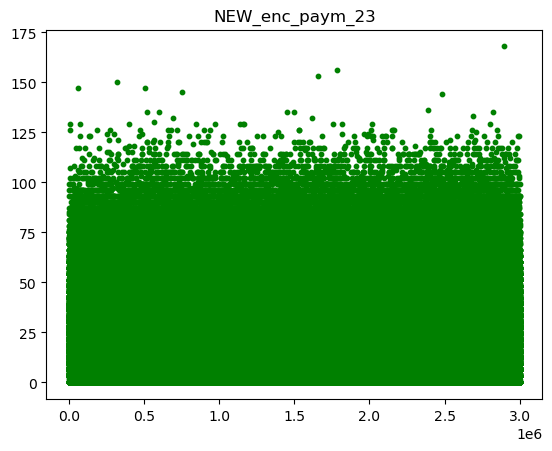

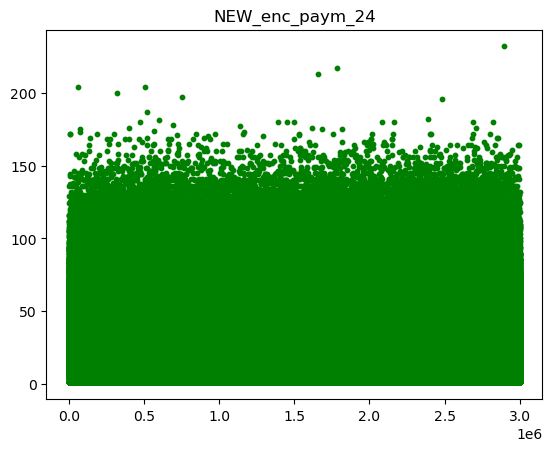

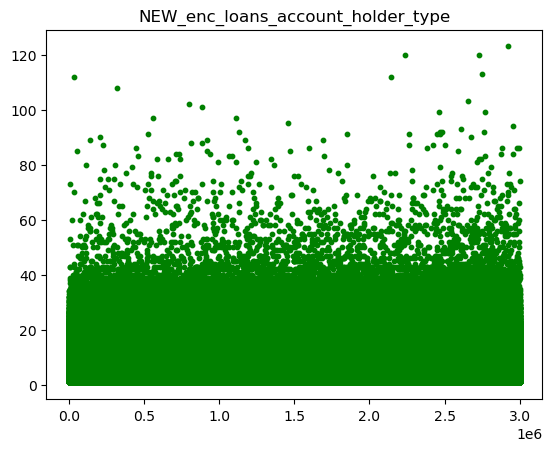

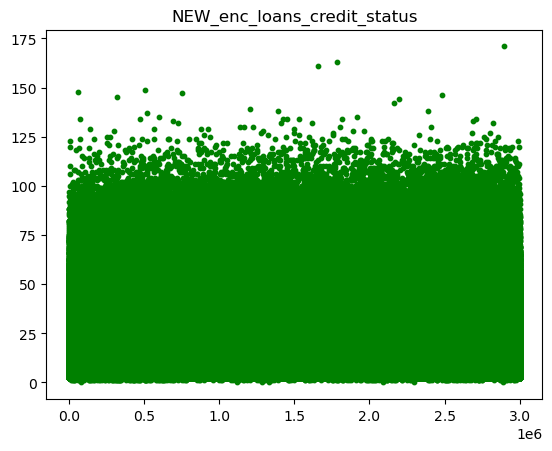

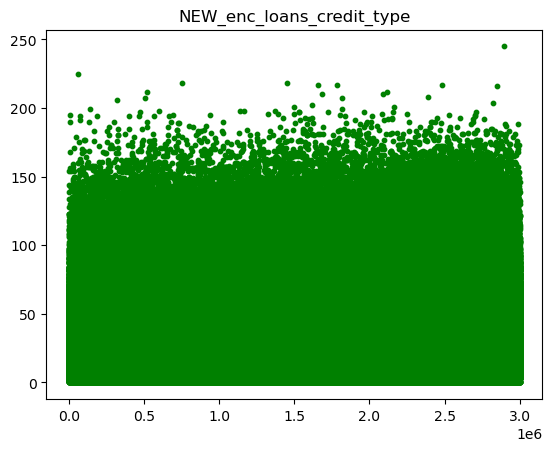

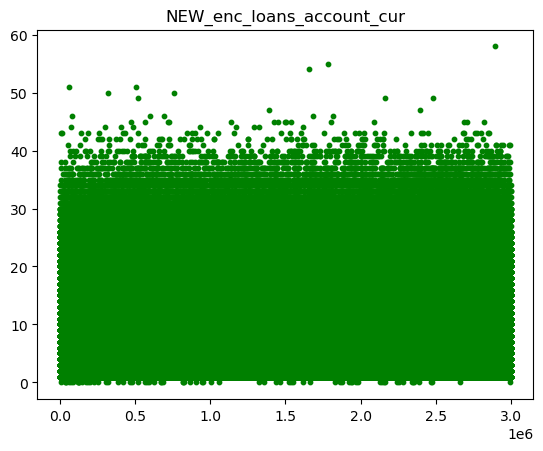

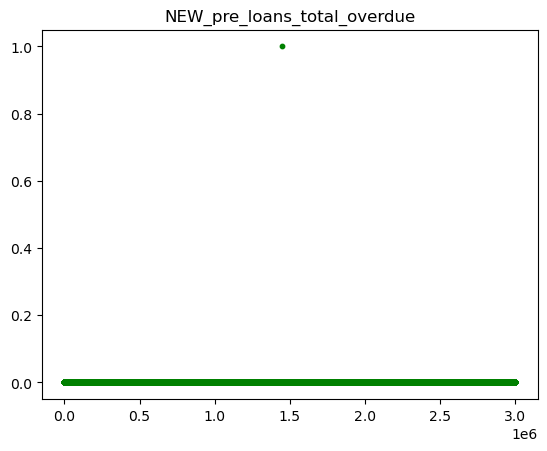

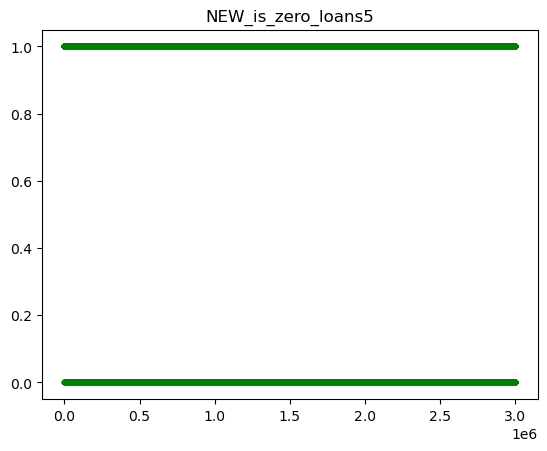

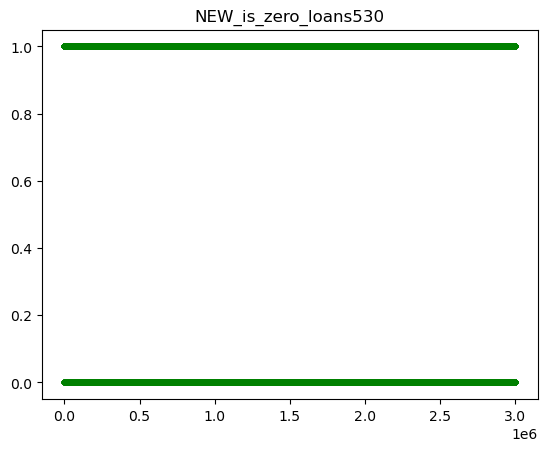

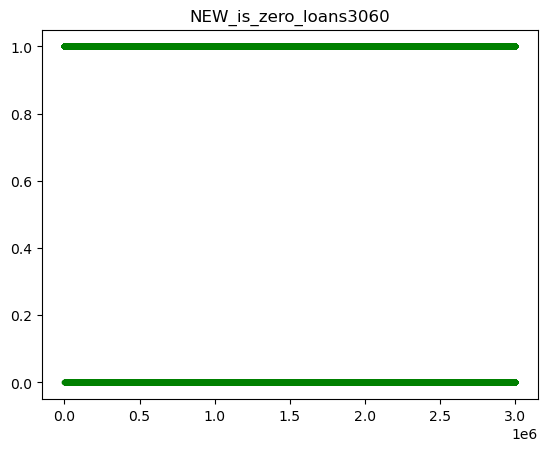

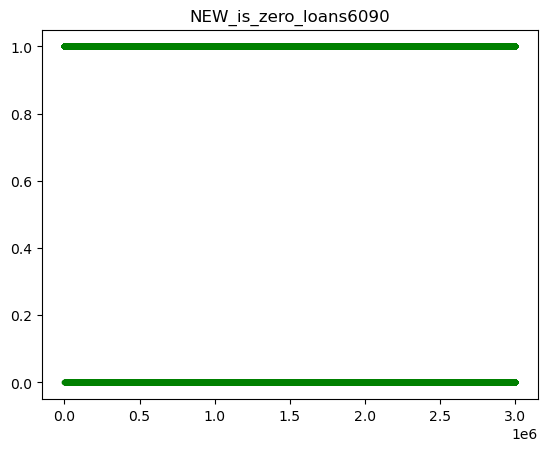

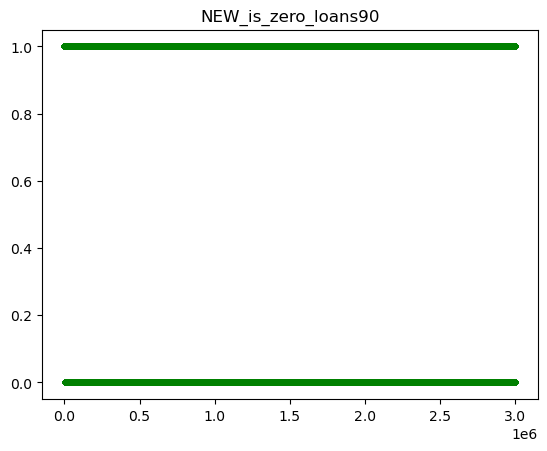

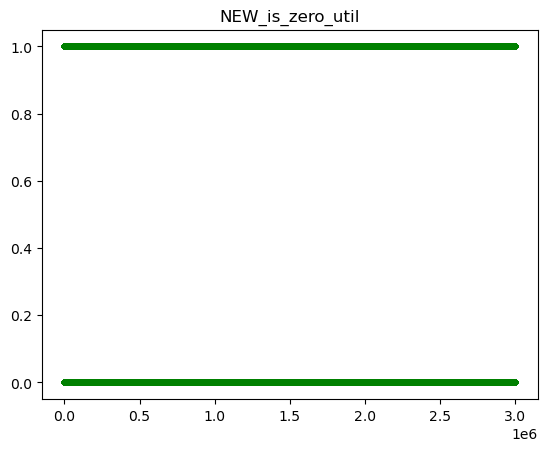

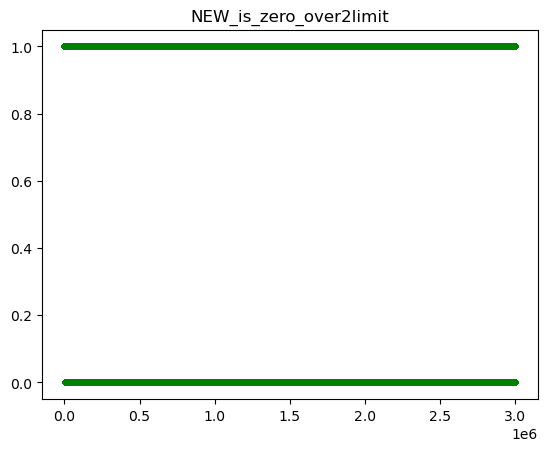

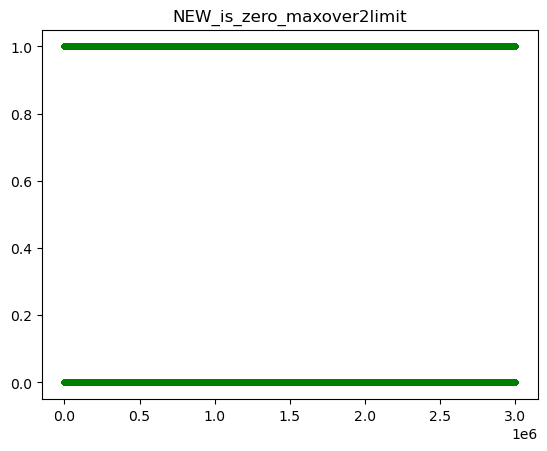

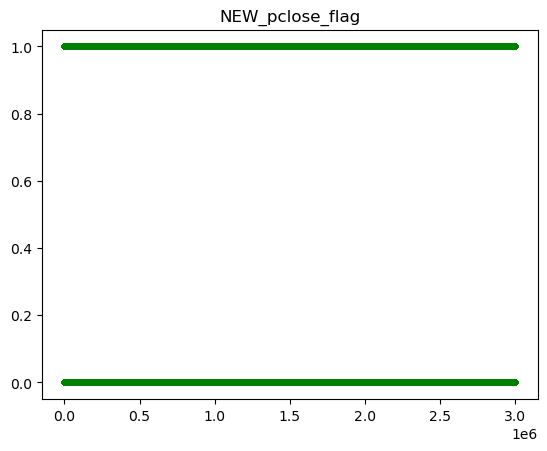

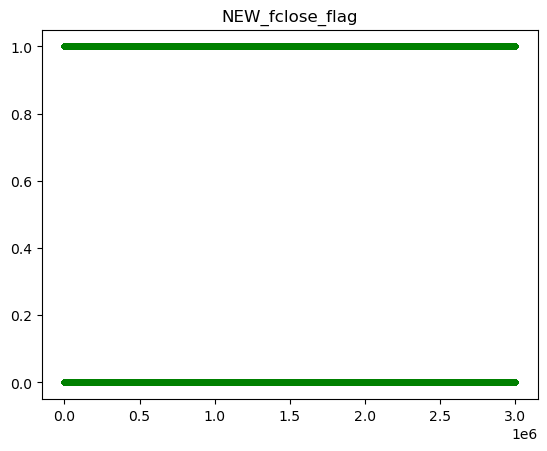

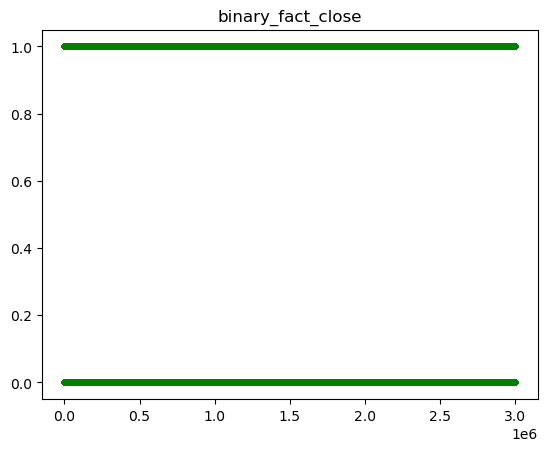

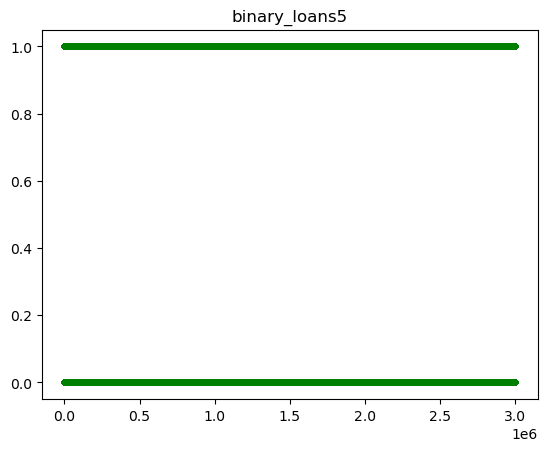

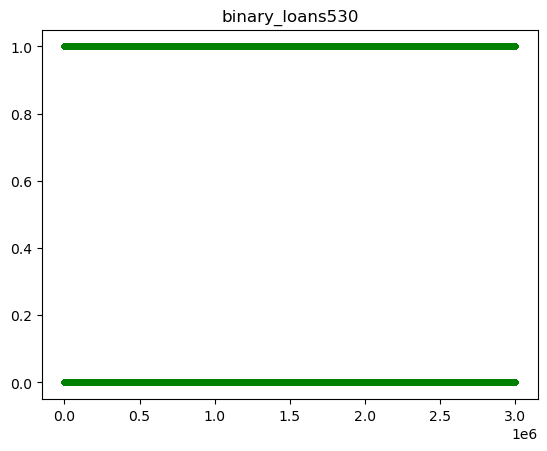

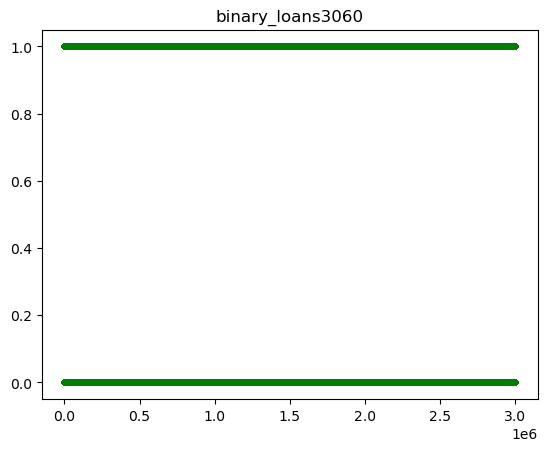

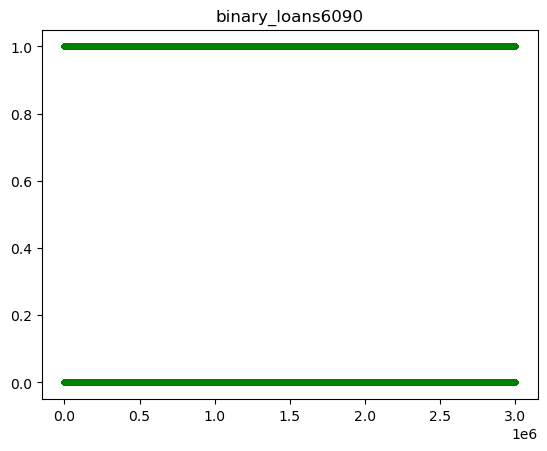

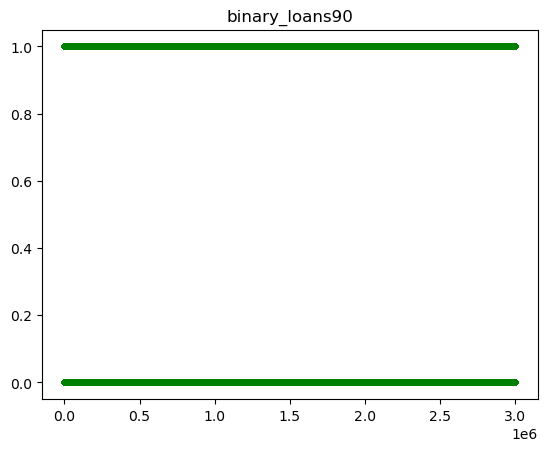

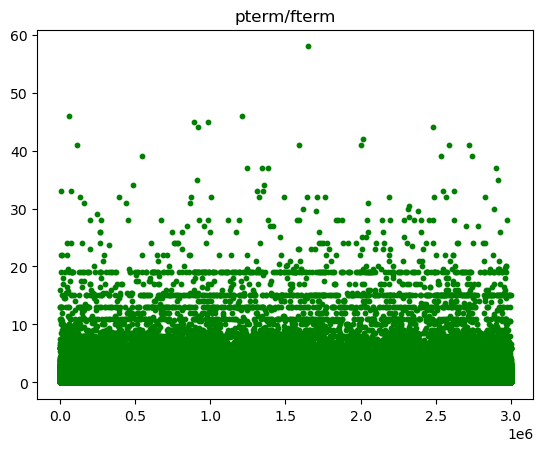

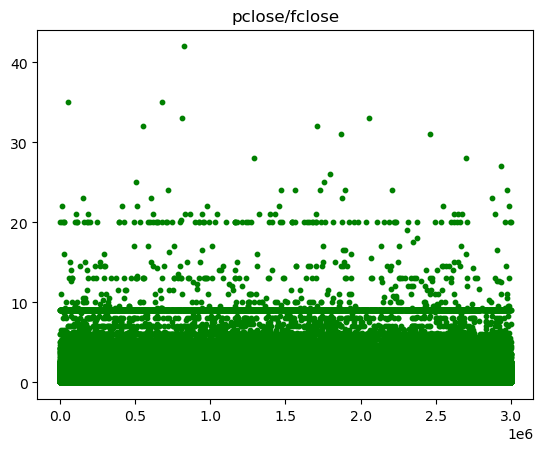

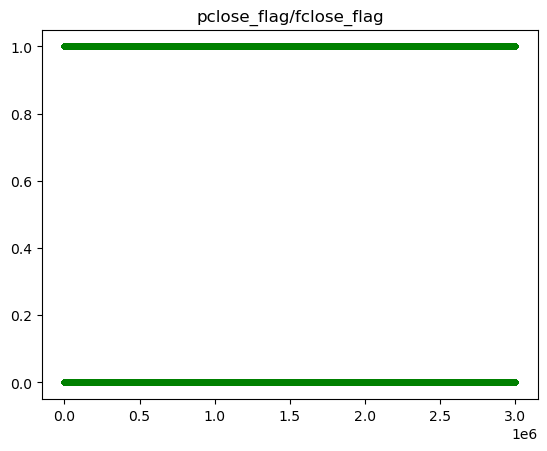

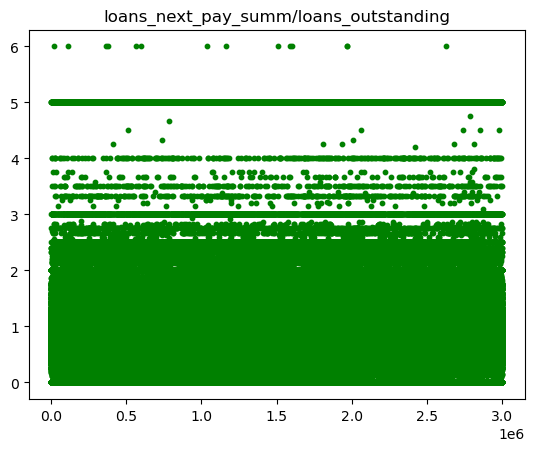

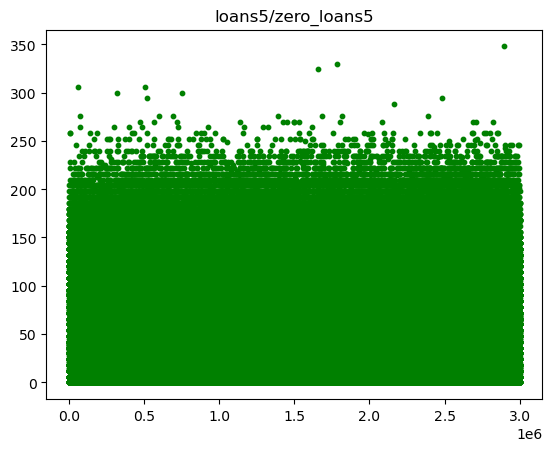

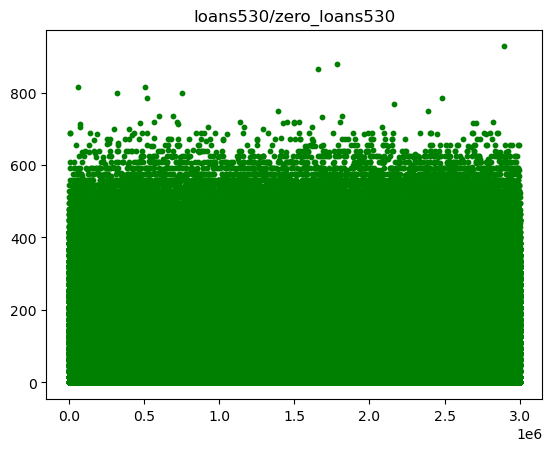

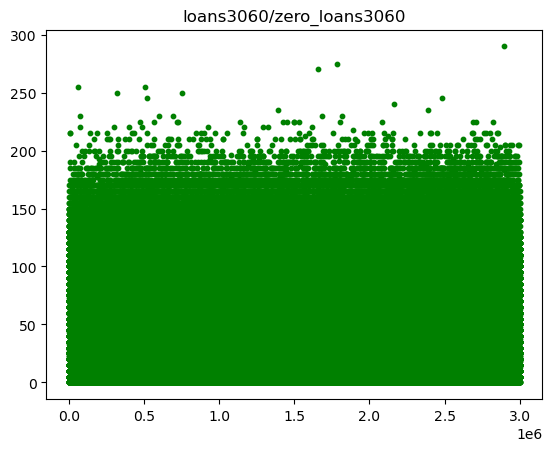

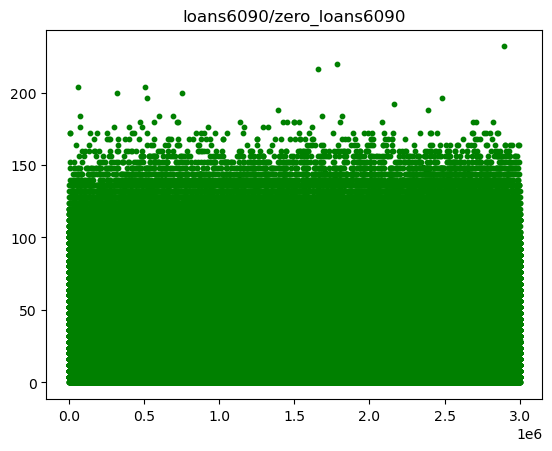

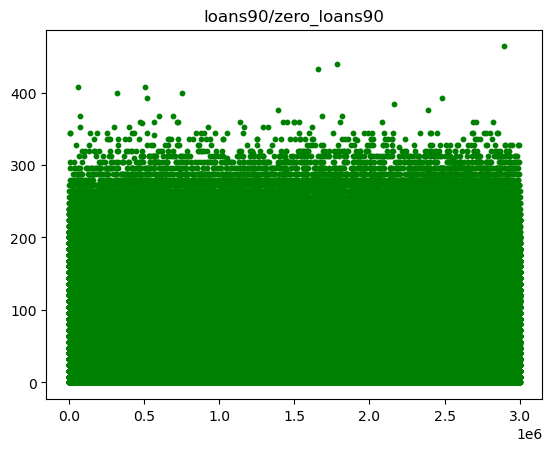

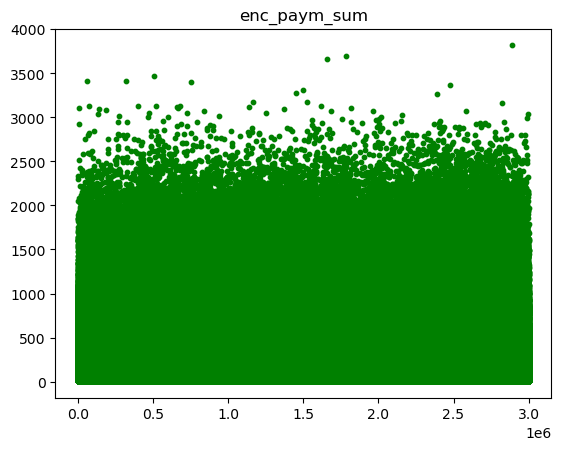

In [218]:
for col in df4.columns:
    plt.scatter(df4.index, df4[col], c='g', s=10)
    plt.title(col)
    plt.show()

# Выявил лишний признак 'SUM_pre_loans_total_overdue'. Имеет одно значение почти во всех строках

In [858]:
df4['NEW_pre_loans_total_overdue'].value_counts()

NEW_pre_loans_total_overdue
0    2999999
1          1
Name: count, dtype: int64

# Удаляю лишние колонки

In [859]:
df5 = df4.drop(columns=['NEW_pre_loans_total_overdue', 'id', 'NEW_rn'])

In [860]:
df5.tail()

,flag,NEW_pre_since_opened,NEW_pre_since_confirmed,NEW_pre_pterm,NEW_pre_fterm,NEW_pre_till_pclose,NEW_pre_till_fclose,NEW_pre_loans_credit_limit,NEW_pre_loans_next_pay_summ,NEW_pre_loans_outstanding,...,binary_loans90,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
2999995,0,97,101,98,98,97,97,81,25,35,...,0,1.000000,1.000000,0.714355,66.0,170.0,55.0,44.0,88.0,359
2999996,0,104,148,117,110,82,89,151,25,40,...,0,1.063477,0.921387,0.625000,78.0,208.0,65.0,52.0,104.0,501
2999997,0,81,78,85,78,82,91,70,24,32,...,0,1.089844,0.900879,0.750000,60.0,160.0,50.0,40.0,80.0,404
2999998,0,58,46,39,47,30,39,57,13,18,...,1,0.829590,0.769043,0.722168,30.0,80.0,25.0,20.0,40.0,332
2999999,0,77,110,92,114,99,105,122,35,33,...,0,0.807129,0.942871,1.060547,72.0,192.0,60.0,48.0,96.0,415


# Решил не применять квантили, так как при стандартных значениях выборка сильно обрезается. Да и на графиках особо нет выбросов.

In [49]:
def quantilecount(dframe):

    dframe2 = dframe.copy()

    for col in dframe.drop(columns='flag'):

        qMin = dframe[col].quantile(0.25)
        qMax = dframe[col].quantile(0.75)
        iqr = qMax - qMin
        bounds = (qMin - iqr*1.5, iqr*1.5 + qMax)

        dframe2 = dframe2[dframe2[col] >= bounds[0]].copy()
        dframe2 = dframe2[dframe2[col] <= bounds[1]].copy()

    return dframe2.reset_index(drop=True)

# Стандартизирую значения во всей таблице, но не целевую переменную

In [861]:
cols = binarycols(df5)
cols

C:\Users\VaL\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


['flag',
 'NEW_is_zero_loans5',
 'NEW_is_zero_loans530',
 'NEW_is_zero_loans3060',
 'NEW_is_zero_loans6090',
 'NEW_is_zero_loans90',
 'NEW_is_zero_util',
 'NEW_is_zero_over2limit',
 'NEW_is_zero_maxover2limit',
 'NEW_pclose_flag',
 'NEW_fclose_flag',
 'binary_fact_close',
 'binary_loans5',
 'binary_loans530',
 'binary_loans3060',
 'binary_loans6090',
 'binary_loans90']

In [862]:
scaler = StandardScaler().fit_transform(df5.drop(columns=cols))

df6 = pd.DataFrame(data=scaler, columns=df5.drop(columns=cols).columns)

df6 = pd.concat([df5[cols], df6], axis=1)

In [863]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 74 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   flag                                   int8   
 1   NEW_is_zero_loans5                     int8   
 2   NEW_is_zero_loans530                   int8   
 3   NEW_is_zero_loans3060                  int8   
 4   NEW_is_zero_loans6090                  int8   
 5   NEW_is_zero_loans90                    int8   
 6   NEW_is_zero_util                       int8   
 7   NEW_is_zero_over2limit                 int8   
 8   NEW_is_zero_maxover2limit              int8   
 9   NEW_pclose_flag                        int8   
 10  NEW_fclose_flag                        int8   
 11  binary_fact_close                      int8   
 12  binary_loans5                          int8   
 13  binary_loans530                        int8   
 14  binary_loans3060                       int8   
 15

# Смотрю распределение целевых классов

In [864]:
df6.flag.value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

In [865]:
df6.shape

(3000000, 74)

In [866]:
df6.tail()

,flag,NEW_is_zero_loans5,NEW_is_zero_loans530,NEW_is_zero_loans3060,NEW_is_zero_loans6090,NEW_is_zero_loans90,NEW_is_zero_util,NEW_is_zero_over2limit,NEW_is_zero_maxover2limit,NEW_pclose_flag,...,NEW_enc_loans_account_cur,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
2999995,0,1,1,1,1,1,1,1,1,1,...,0.366084,-0.092463,0.247335,-0.306814,0.376516,0.324115,0.369101,0.369367,0.368756,-0.062672
2999996,0,1,1,1,1,1,1,1,1,1,...,0.689463,0.002398,0.101532,-0.541785,0.700792,0.709475,0.692492,0.692966,0.692196,0.411779
2999997,0,1,1,1,1,1,1,1,1,1,...,0.204395,0.041802,0.063496,-0.213083,0.214377,0.222704,0.207405,0.207568,0.207036,0.087682
2999998,0,1,1,1,1,1,1,1,1,1,...,-0.604052,-0.347126,-0.181020,-0.286270,-0.596314,-0.588580,-0.601075,-0.601428,-0.601563,-0.152885
2999999,0,1,1,1,1,1,1,1,1,1,...,0.527774,-0.380692,0.141379,0.603538,0.538654,0.547218,0.530797,0.531166,0.530476,0.124436


# Так как имеется дисбаланс в целевой переменной, я решил сделать случайную выборку из строк, соответствующих значению целевой переменной большего класса ("0"), количеством равным удвоенному количеству значений меньшего класса. Что бы всё-таки значимость класса "0", когда кредит не надо выдавать, была выше, так как для банка это важнее.

In [867]:
train, test = train_test_split(df6[df6.flag==0], test_size=df6.flag.value_counts()[1]*2, random_state=42)

In [868]:
df7 = pd.concat([test, df6[df6.flag==1]]).reset_index(drop=True)

In [869]:
df7.tail()

,flag,NEW_is_zero_loans5,NEW_is_zero_loans530,NEW_is_zero_loans3060,NEW_is_zero_loans6090,NEW_is_zero_loans90,NEW_is_zero_util,NEW_is_zero_over2limit,NEW_is_zero_maxover2limit,NEW_pclose_flag,...,NEW_enc_loans_account_cur,pterm/fterm,pclose/fclose,loans_next_pay_summ/loans_outstanding,loans5/zero_loans5,loans530/zero_loans530,loans3060/zero_loans3060,loans6090/zero_loans6090,loans90/zero_loans90,enc_paym_sum
319321,1,1,1,1,1,1,1,1,1,0,...,0.204395,-0.231834,-0.133022,-0.432646,0.214377,0.222704,0.207405,0.207568,0.207036,0.117753
319322,1,1,1,1,1,1,1,1,1,1,...,-0.765741,0.326383,0.495473,-0.163007,-0.758452,-0.750837,-0.762770,-0.763227,-0.763283,-0.861221
319323,1,1,1,1,1,1,1,1,1,1,...,-0.280673,-0.543415,-0.247129,-0.432646,-0.272037,-0.264067,-0.277683,-0.277830,-0.278124,-0.476982
319324,1,1,1,1,1,1,1,1,1,1,...,-0.118984,1.763884,0.212016,-0.273430,-0.190968,-0.132233,-0.213004,-0.237380,-0.116404,0.318226
319325,1,1,1,1,1,1,1,1,1,1,...,0.689463,0.253413,0.103343,0.079668,0.700792,0.709475,0.692492,0.692966,0.692196,0.438509


In [870]:
df7.flag.value_counts()

flag
0    212884
1    106442
Name: count, dtype: int64

In [275]:
emptyval(df7)

Done


In [276]:
infval(df7)

Done


In [871]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319326 entries, 0 to 319325
Data columns (total 74 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   flag                                   319326 non-null  int8   
 1   NEW_is_zero_loans5                     319326 non-null  int8   
 2   NEW_is_zero_loans530                   319326 non-null  int8   
 3   NEW_is_zero_loans3060                  319326 non-null  int8   
 4   NEW_is_zero_loans6090                  319326 non-null  int8   
 5   NEW_is_zero_loans90                    319326 non-null  int8   
 6   NEW_is_zero_util                       319326 non-null  int8   
 7   NEW_is_zero_over2limit                 319326 non-null  int8   
 8   NEW_is_zero_maxover2limit              319326 non-null  int8   
 9   NEW_pclose_flag                        319326 non-null  int8   
 10  NEW_fclose_flag                        319326 non-null  

In [872]:
cols = binarycols(df7)
cols

['flag',
 'NEW_is_zero_loans5',
 'NEW_is_zero_loans530',
 'NEW_is_zero_loans3060',
 'NEW_is_zero_loans6090',
 'NEW_is_zero_loans90',
 'NEW_is_zero_util',
 'NEW_is_zero_over2limit',
 'NEW_is_zero_maxover2limit',
 'NEW_pclose_flag',
 'NEW_fclose_flag',
 'binary_fact_close',
 'binary_loans5',
 'binary_loans530',
 'binary_loans3060',
 'binary_loans6090',
 'binary_loans90']

In [946]:
df8 = df7[['flag',
           
           'NEW_is_zero_loans5',
           'NEW_is_zero_loans530',
           'NEW_is_zero_loans3060',
           'NEW_is_zero_loans6090',
           'NEW_is_zero_loans90',
           'NEW_is_zero_util',
           'NEW_is_zero_over2limit',
           'NEW_is_zero_maxover2limit',
           'NEW_pclose_flag',
           'NEW_fclose_flag',
           
#            'binary_fact_close',
#            'binary_loans5',
#            'binary_loans530',
#            'binary_loans3060',
           'binary_loans6090',
           'binary_loans90',
           
           'pterm/fterm',
           'pclose/fclose',
           'loans_next_pay_summ/loans_outstanding',
           'loans5/zero_loans5',
           'loans530/zero_loans530',
           'loans3060/zero_loans3060',
           'loans6090/zero_loans6090',
           'loans90/zero_loans90',
           'enc_paym_sum'
        
          ]]

# Applying

# Отбираю лучшую модель с лучшими параметрами которая будет применена в итоговом Pipeline

In [339]:
train, test = train_test_split(df7, test_size=0.01, random_state=42)
xx = test.drop(columns='flag')
yy = test.flag

xtrain, xtest, ytrain, ytest = train_test_split(xx, yy, test_size=0.3, random_state=42)

In [340]:
xtrain.shape

(2235, 69)

### Тестирую RandomForestClassifier

In [31]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
param ={
        'max_depth': [10, 100, 200, None],
        'max_features': ['sqrt', 'log2', None]
        }

RFCGC = GridSearchCV(rfc, param_grid=param, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5).fit(xtrain, ytrain)

print(f'best_params_: {RFCGC.best_params_}')
print(f'best_score_: {RFCGC.best_score_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best_params_: {'max_depth': 10, 'max_features': 'log2'}
best_score_: 0.6646136221032964


In [32]:
roc_auc_score(ytest, RFCGC.predict_proba(xtest)[:, 1])

0.6540167906627533

### Тестирую SVC

In [53]:
svc = SVC(probability=True, cache_size=10000)
param ={
        'C': [i for i in np.arange(3, 8)],
        'gamma': ['auto', 'scale'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
       }

SVCGS = GridSearchCV(svc, param_grid=param, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5).fit(xtrain, ytrain)

print(f'best_params_: {SVCGS.best_params_}')
print(f'best_score_: {SVCGS.best_score_}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
best_params_: {'C': 4, 'gamma': 'scale', 'kernel': 'rbf'}
best_score_: 0.6888311194284136


In [54]:
roc_auc_score(ytest, SVCGS.predict_proba(xtest)[:, 1])

0.7002118644067796

### Тестирую LogisticRegression

In [33]:
lr = LogisticRegression(max_iter=10000, random_state=42)
param ={
        'C': [i for i in np.arange(1, 4)],
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
       }

LRGS = GridSearchCV(lr, param_grid=param, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5).fit(xtrain, ytrain)

print(f'best_params_: {LRGS.best_params_}')
print(f'best_score_: {LRGS.best_score_}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
best_params_: {'C': 1, 'solver': 'saga'}
best_score_: 0.6785885592375899


In [34]:
roc_auc_score(ytest, LRGS.predict_proba(xtest)[:, 1])

0.6785494895521516

### Тестирую MLPClassifier

In [35]:
mlp = MLPClassifier(max_iter=10000, random_state=42)
param ={
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'shuffle': [True, False]
       }

MLPGS = GridSearchCV(mlp, param_grid=param, scoring='roc_auc', n_jobs=-1, verbose=3, cv=5).fit(xtrain, ytrain)

print(f'best_params_: {MLPGS.best_params_}')
print(f'best_score_: {MLPGS.best_score_}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
best_params_: {'activation': 'tanh', 'learning_rate': 'adaptive', 'shuffle': True, 'solver': 'sgd'}
best_score_: 0.6849033907920796


In [36]:
roc_auc_score(ytest, MLPGS.predict_proba(xtest)[:, 1])

0.6882465360726231

### Создаю нейросеть

In [947]:
train, test = train_test_split(df8, test_size=0.1, random_state=42)

x = test.drop(columns='flag')
y = test.flag

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

In [948]:
xtrain.shape

(22353, 21)

In [949]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

In [950]:
class Creditset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.to_numpy().astype('float32'))
        self.y = torch.tensor(y.to_numpy().astype('float32'))
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.shape[0]

In [951]:
train_data = Creditset(xtrain, ytrain)

In [967]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

In [968]:
for i, (xb, yb) in enumerate(train_dataloader):
    print(i, xb.shape, yb.shape)

0 torch.Size([64, 21]) torch.Size([64])
1 torch.Size([64, 21]) torch.Size([64])
2 torch.Size([64, 21]) torch.Size([64])
3 torch.Size([64, 21]) torch.Size([64])
4 torch.Size([64, 21]) torch.Size([64])
5 torch.Size([64, 21]) torch.Size([64])
6 torch.Size([64, 21]) torch.Size([64])
7 torch.Size([64, 21]) torch.Size([64])
8 torch.Size([64, 21]) torch.Size([64])
9 torch.Size([64, 21]) torch.Size([64])
10 torch.Size([64, 21]) torch.Size([64])
11 torch.Size([64, 21]) torch.Size([64])
12 torch.Size([64, 21]) torch.Size([64])
13 torch.Size([64, 21]) torch.Size([64])
14 torch.Size([64, 21]) torch.Size([64])
15 torch.Size([64, 21]) torch.Size([64])
16 torch.Size([64, 21]) torch.Size([64])
17 torch.Size([64, 21]) torch.Size([64])
18 torch.Size([64, 21]) torch.Size([64])
19 torch.Size([64, 21]) torch.Size([64])
20 torch.Size([64, 21]) torch.Size([64])
21 torch.Size([64, 21]) torch.Size([64])
22 torch.Size([64, 21]) torch.Size([64])
23 torch.Size([64, 21]) torch.Size([64])
24 torch.Size([64, 21]) to

258 torch.Size([64, 21]) torch.Size([64])
259 torch.Size([64, 21]) torch.Size([64])
260 torch.Size([64, 21]) torch.Size([64])
261 torch.Size([64, 21]) torch.Size([64])
262 torch.Size([64, 21]) torch.Size([64])
263 torch.Size([64, 21]) torch.Size([64])
264 torch.Size([64, 21]) torch.Size([64])
265 torch.Size([64, 21]) torch.Size([64])
266 torch.Size([64, 21]) torch.Size([64])
267 torch.Size([64, 21]) torch.Size([64])
268 torch.Size([64, 21]) torch.Size([64])
269 torch.Size([64, 21]) torch.Size([64])
270 torch.Size([64, 21]) torch.Size([64])
271 torch.Size([64, 21]) torch.Size([64])
272 torch.Size([64, 21]) torch.Size([64])
273 torch.Size([64, 21]) torch.Size([64])
274 torch.Size([64, 21]) torch.Size([64])
275 torch.Size([64, 21]) torch.Size([64])
276 torch.Size([64, 21]) torch.Size([64])
277 torch.Size([64, 21]) torch.Size([64])
278 torch.Size([64, 21]) torch.Size([64])
279 torch.Size([64, 21]) torch.Size([64])
280 torch.Size([64, 21]) torch.Size([64])
281 torch.Size([64, 21]) torch.Siz

In [969]:
class Creditnet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        self.f1 = nn.ReLU()
        
        self.output = nn.Linear(hidden_dim, output_dim)
        
        self.f2 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.f1(self.hidden(x))
        x = self.f2(self.output(x))
        return x

In [970]:
creditnet = Creditnet(xtrain.shape[1], 512, 1)
creditnet

Creditnet(
  (hidden): Linear(in_features=21, out_features=512, bias=True)
  (f1): ReLU()
  (output): Linear(in_features=512, out_features=1, bias=True)
  (f2): Sigmoid()
)

In [971]:
optimizer = torch.optim.SGD(creditnet.parameters(), lr=0.01)

In [972]:
loss_fn = nn.BCELoss()
lossplot = []

for epoch in range(50):
    for x, y in train_dataloader:
        pred = creditnet(x)
        loss = loss_fn(pred, y.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = loss_fn(pred, y.unsqueeze(-1))
    lossplot.append(loss.item())

In [973]:
min(lossplot)

0.4792821407318115

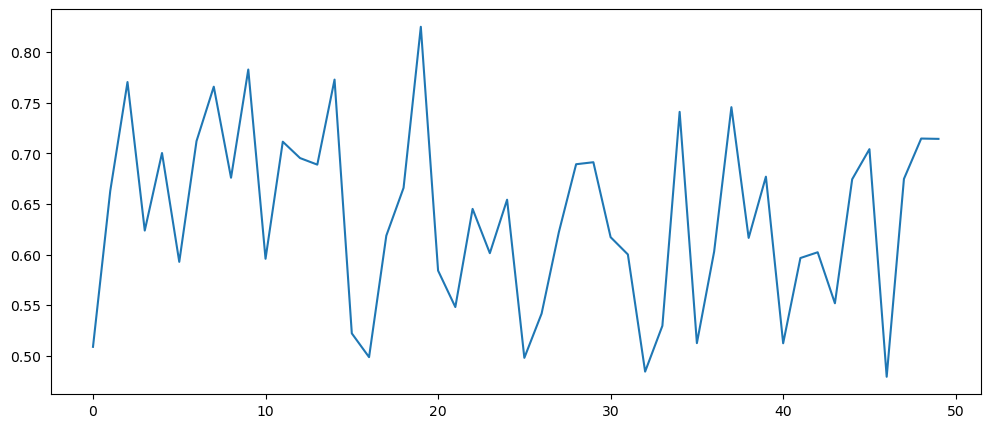

In [974]:
fig, ax = plt.subplots(figsize=[12,5])
ax.plot(lossplot)
plt.show()

In [975]:
with torch.no_grad():
    pred = creditnet(torch.tensor(xtest.to_numpy().astype('float32')))

In [976]:
pred1 = np.round(np.array(pred))

In [977]:
confusion_matrix(ytest, pred1)

array([[6120,  299],
       [2795,  366]], dtype=int64)

In [978]:
roc_auc_score(ytest, pred)

0.6254121456789125

# Pipeline

## Загружаю целевую и признаковые переменные, паралельно меняя тип данных для экономии ресурсов

In [582]:
creditX = pd.DataFrame()
for i in range(12):
  creditX = pd.concat(
                     [creditX,
                      pd.concat(
                                [pd.read_parquet(fr'C:\Users\VaL\PycharmProjects\Credit\train_data\train_data_{i}.pq', columns=['id']),
                                 pd.read_parquet(fr'C:\Users\VaL\PycharmProjects\Credit\train_data\train_data_{i}.pq').drop(columns='id').astype('int8')],
                          axis=1)]
                     )

creditY =  pd.concat(
                     [pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\train_target.csv', usecols=['id']),
                      pd.read_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\train_target.csv').drop(columns='id').astype('int8')],
                          axis=1)

## Создаю функции для группировки признаков и соединения их с целевой преременной.
## А также написал функцию "balancer", которая изменяет баланс классов целевой переменной.

In [583]:
def groupmerge(dframeX, dframeY):
    dframeX2 = dframeX.groupby(['id'], as_index=False).sum().add_prefix('SUM_').reset_index(drop=True)
    dframeX3 = dframeX2.drop(columns='SUM_id').astype('int16')
    dframeX3['id'] = dframeX2.SUM_id
    dframeX3Y = creditY.merge(dframeX3, on='id', how='inner')
    return dframeX3Y

def balancer(dframe):
    train, test = train_test_split(dframe[dframe.flag==0], test_size=dframe.flag.value_counts()[1]*2, random_state=42)
    dframe2 = pd.concat([test, dframe[dframe.flag==1]]).reset_index(drop=True)
    return dframe2

## Создаю функции для "FunctionTransformer"

In [586]:
def newfeatures(dframe):
    dframe2 = dframe.copy()

    dframe2['pterm/fterm'] = (dframe2.SUM_pre_pterm / dframe2.SUM_pre_fterm).astype('float16')
    dframe2['pclose/fclose'] = (dframe2.SUM_pre_till_pclose / dframe2.SUM_pre_till_fclose).astype('float16')
    dframe2['pclose_flag/fclose_flag'] = (dframe2.SUM_pclose_flag / dframe2.SUM_fclose_flag).astype('float16')
    dframe2['loans_next_pay_summ/loans_outstanding'] = (dframe2.SUM_pre_loans_next_pay_summ / dframe2.SUM_pre_loans_outstanding).astype('float16')
    dframe2['loans5/zero_loans5'] = (dframe2.SUM_pre_loans5 / dframe2.SUM_is_zero_loans5).astype('float16')
    dframe2['loans530/zero_loans530'] = (dframe2.SUM_pre_loans530 / dframe2.SUM_is_zero_loans530).astype('float16')
    dframe2['loans3060/zero_loans3060'] = (dframe2.SUM_pre_loans3060 / dframe2.SUM_is_zero_loans3060).astype('float16')
    dframe2['loans6090/zero_loans6090'] = (dframe2.SUM_pre_loans6090 / dframe2.SUM_is_zero_loans6090).astype('float16')
    dframe2['loans90/zero_loans90'] = (dframe2.SUM_pre_loans90 / dframe2.SUM_is_zero_loans90).astype('float16')

    dframe2['enc_paym_sum'] = dframe2.SUM_enc_paym_0
    for i in range(1, 25):
        dframe2['enc_paym_sum'] = (dframe2['enc_paym_sum'] + dframe2[f'SUM_enc_paym_{i}']).astype('int16')
    return dframe2


pipe_newfeatures = FunctionTransformer(newfeatures)
############################################################################################


def replacingval(dframe):
    dframe2 = dframe.copy()
    return dframe2.replace([np.inf, -np.inf, np.nan], 0)


pipe_replacingval = FunctionTransformer(replacingval)
############################################################################################


def dropper(dframe):
    dframe2 = dframe.drop(columns=['id', 'SUM_rn', 'SUM_pre_loans_total_overdue'])
    return dframe2


pipe_dropper = FunctionTransformer(dropper)

In [588]:
def nn(dframe):
    
    dframe2=dframe.copy()
    
    class Creditset(Dataset):
        def __init__(self, x, y):
            self.x = torch.tensor(x.to_numpy().astype('float32'))
            self.y = torch.tensor(y.to_numpy().astype('float32'))

        def __getitem__(self, index):
            return self.x[index], self.y[index]

        def __len__(self):
            return self.x.shape[0]


    train_data = Creditset(xtrain, ytrain)


    train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)


    class Creditnet(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super().__init__()

            self.hidden = nn.Linear(input_dim, hidden_dim)

            self.f1 = nn.ReLU()

            self.output = nn.Linear(hidden_dim, output_dim)

            self.f2 = nn.Sigmoid()

        def forward(self, x):
            x = self.f1(self.hidden(x))
            x = self.f2(self.output(x))
            return x


    creditnet = Creditnet(73, 128, 1)


    loss_fn = nn.MSELoss()
    lossplot = []


    optimizer = torch.optim.SGD(creditnet.parameters(), lr=0.1)


    for epoch in range(100):
        for x, y in train_dataloader:
            pred = creditnet(x)
            loss = loss_fn(pred, y.unsqueeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        loss = loss_fn(pred, y.unsqueeze(-1))
        lossplot.append(loss.item())


    with torch.no_grad():
        pred = creditnet(torch.tensor(xtest.to_numpy()))
        
    return dframe2


pipe_nn = FunctionTransformer(nn)

## Собираю Pipeline на основе лучшей модели с лучшими параметрами.

In [589]:
preparation = Pipeline([
    ('pipe_newfeatures', pipe_newfeatures),
    ('pipe_replacingval', pipe_replacingval),
    ('pipe_dropper', pipe_dropper),
], verbose=True)

columns = make_column_selector(dtype_include=['int', 'float'])

coltrans = ColumnTransformer([('transformer', StandardScaler(), columns)], remainder='passthrough')

pipe = Pipeline([
    ('preparation', preparation),
    ('coltrans', coltrans),
    ('pip_nn', pipe_nn)

 
], verbose=True)

## Применяю на всех данных

In [37]:
CREDIT = groupmerge(creditX, creditY)

In [38]:
trainXY = balancer(CREDIT)

In [39]:
x = trainXY.drop(columns='flag')
y = trainXY.flag

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

In [40]:
print('train: ',xtrain.shape)
print('test: ',xtest.shape)

train:  (298037, 61)
test:  (127731, 61)


In [41]:
result = pipe.fit(xtrain, ytrain)

[Pipeline] .. (step 1 of 3) Processing pipe_newfeatures, total=   0.1s
[Pipeline] . (step 2 of 3) Processing pipe_replacingval, total=   0.1s
[Pipeline] ...... (step 3 of 3) Processing pipe_dropper, total=   0.0s
[Pipeline] ....... (step 1 of 3) Processing preparation, total=   0.3s
[Pipeline] .......... (step 2 of 3) Processing coltrans, total=   0.1s
[Pipeline] ..... (step 3 of 3) Processing MLPClassifier, total=95.0min


In [42]:
pred = result.predict(xtest)

In [43]:
confusion_matrix(ytest, pred)

array([[92501,  3232],
       [27576,  4422]], dtype=int64)

In [44]:
roc_auc_score(ytest, result.predict_proba(xtest)[:, 1])

0.7111013581499587

In [ ]:
with open(r'C:\Users\VaL\Downloads\DataScience\Credit\result_pipeline.pkl', 'wb') as dillfile:
    dill.dump(result, dillfile)

In [ ]:
pd.Series(pred).to_csv(r'C:\Users\VaL\Downloads\DataScience\Credit\pred_test.csv', index=False)